# <span style='color:SteelBlue'>P3 - Préparez des données pour un organisme de santé publique</span>

![Logo Academy](https://www.paca.ars.sante.fr/sites/default/files/2017-01/spf.jpg)


# <span style='background:blue'>Introduction</span>


Santé publique France propose  **est un établissement public à caractère administratif français, placé sous la tutelle du ministère chargé de la santé**, crée le 1er mai 2016.

___

**Mission**

Nettoyage et exploration des données de l’Agence publique France, afin de déterminer la faisabilité de la création d’un système de suggestion ou d’auto-complétion pour aider leurs usagers à remplir plus efficacement la base de données de l’Agence publique France.

___

**Source des datasets**<br>
[Open Food Facts](https://world.openfoodfacts.org/)<br>
Les variables sont définies [ici](https://world.openfoodfacts.org/data/data-fields.txt)

1 fichier CSV :
- fr.openfoodfacts.org.products.csv
___

**Sommaire**

Importations des librairies utilisées dans ce notebook <br><br>
Créations des fonctions utilisées dans ce notebook

**Etape 1 : Description des données**
- _Apparence graphique_
- _Nombre de ligne et colonnes_
- _Nom et description des variables_
- _Type de données_
- _Résumé des variables_
  - _Quantitatives_
  - _Qualitatives_
- _Valeurs manquantes_
- _Doublons_<br><br>

**Etape 2 : Nettoyage des données**
- _Définition des variables_
- _Gestion des valeurs aberrantes_
- _Gestion des valeurs manquantes_
  - Remplacer par 0, moyenne ou médiane
  - Estimer valeurs manquantes
    - ML Algorithme KNN
    - Fonction « IterativeImputer » (cas de corrélation)
<br><br>

**Etape 3 : Analyse exploratoire**
 - Analyses univariéees
 - Analyses bivariéees
 - Analyses multivariéees
   - ACP
   - ANOVA
___

**Conclusion**

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [253]:
# Librairies
import datetime
import os.path
import sys
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import math
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import warnings

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('Missingno     : ' + msno.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Seaborn       : ' + sns.__version__)
print('sklearn       : ' + sklearn.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

Version des librairies utilisées :
Python        : 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
Matplotlib    : 3.7.2
Missingno     : 0.5.2
NumPy         : 1.25.2
Pandas        : 2.1.0
Seaborn       : 0.12.2
sklearn       : 1.3.0

Code lancé le : 2023-09-22T18:17:42.147944


In [254]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Ignorez les avertissements de type FutureWarning pour Seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

In [247]:
# Création d'1 palette de couleurs
colors1 = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# <span style='background:grey'>Créations des fonctions utilisées dans ce notebook</span>

In [62]:
#                      NOMBRE DE LIGNES ET DE COLONNES
# ****************************************************************************

def print_nbr_ligne_col(df):
    """
    Procédure qui affiche le nombre de lignes et de colonnes du data frame
    
    :param: df : data frame à analyser (df)
    """
    
    # Affichage dimension du dataframe (linge et col)
    dim = df.shape
    print('{0} ligne(s) x {1} colonne(s)\n'.format(str(dim[0]), str(dim[1])))

In [63]:
#                              COMPTEUR TYPE DES VARIABLES
# ****************************************************************************

def compteur_type_variable(df, listing, tableau_repartition, graph):
    """
    Procédure qui affiche :
        - un listing des variables et leur type
        - un tableau de la répartition des variables par type
        - un graphique de répartition des variables par type avec un diagrmme   circulaire
    
    :param: df : data frame à analyser (df)
    :param: listing : True pour afficher le listing des variables (bool)
    :param: tableau_repartition : True pour afficher le tableau de répartition des variables (bool)
    :param: graph : True pour afficher le graph de répartition des variables (bool)
    """
    
    # Liste des variables + type
    if listing :
        print("-" * 100)
        print("Type de variable pour chacune des variables\n")
        display(df.dtypes)
    
    # Type de variable et répartition
    if tableau_repartition :
        print("Répartition des types de variable")
        
        # Calcul du nombre de type de variable et leur répartition
        type_nbr = df.dtypes.value_counts()
        type_nb_tot = type_nbr.sum()
        type_nb_pourcent = round((100 * type_nbr / type_nb_tot), 2)
        
        # Concatenation en 1 data frame
        table = pd.concat([type_nbr, type_nb_pourcent], axis=1)
        table.columns = ['Nombre', 'en %']
        
        # Affichage résultats
        display(table[table['Nombre'] != 0]
                .sort_values('en %', ascending = False,)
                .style.background_gradient('YlGn'))
        
    # Diagramme circulaire 
    if graph :
        df.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.title('Répartition des types de données')
        plt.ylabel('')
        plt.show()

In [64]:
#                             VALEURS MANQUANTES
# ****************************************************************************

def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Procédure qui affiche le nombre de valeurs manquantes, puis :
        - un tableau sur la répartition des valeur manquantes par variable
        - une matrice de répartition des valeurs manquantes par variable
        
    :param: df : data frame à analyser (df)
    :param: tableau : True pour afficher le texte (bool)
    :param: matrice : True pour afficher matrice de répartition (bool)
    """
    
    # Nombre de valeurs manquantes  / nombre de valeur / % de manquantes 
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    
    # Affichage résultat
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(nb_nan_tot, nb_donnees_tot, nb_nan_pourcent))
    
    # Calcul du nombre de valeur manquante et leur pourcentage
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    
    # Concatenation en 1 data frame
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombres de valeurs manquantes', 
                    '% de valeurs manquantes']
    
    # Nombre colonnes concernées
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombres de valeurs manquantes'] != 0]['Nombres de valeurs manquantes'].size

    # tableau sur la répartition des valeur manquantes par variable
    if tableau:
        
        # Affichage texte et tableau
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending = True)
                .style.background_gradient('YlGn'))

    # matrice de répartition des valeurs manquantes par variable
    if matrice:
        
        # Séparateur graphique
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        print("-" * 100)        
        print("Heatmap de visualisation des valeurs manquantes")
        
        # Matrix de Missingno
        msno.matrix(df)

In [65]:
#                          DETECTION DES DOUBLONS
# ****************************************************************************

def detect_doublon(df, var, keep_value):
    """
    Fonction qui détecte les doublons d'un data frame sur une variable (colonne) et qui retourne le nombre de doublon.

    :param: df : data frame à analyser (df)
    :param: var : nom de la variable (str)
    :param: keep_value : nom de méthode pour 'keep' (str)

    :return: nb_doublons : nombre de doublons (float)
    :return: doublons : doublons trouvés (df)
    """
    
    # Méthode 'first'
    if keep_value == 'first':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "first" sur "{0}" : {1}'.format(var, nb_doublons))
        
    # Méthode 'last'
    elif keep_value == 'last':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "last" sur "{0}" : {1}'.format(var, nb_doublons))
    
    # Méthode False
    else:
    
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec False sur "{0}" : {1}\n'.format(var, nb_doublons))
    
    # Output
    return nb_doublons, doublons

In [66]:
#                          FILTRE NAN PAR SEUIL
# ****************************************************************************

def filtre_nan_par_seuil(df: pd.DataFrame, taux, fig_detector):
    """
    Fonction qui filtre les col du df en fonction du nombre de NaN présent dedans, selon un seuil minimum. Il peut afficher le taux de remplissage par col. 

    :param: df : data frame à analyser (df)
    :param: taux : seuil minimum de NaN (int)
    :param: fig_detector : détecteur d'affichage de plot (bool)
    
    :return: df_Nan_par_ligne : data frame des NaN par col (df)
    :return: df_to_supp : data frame des col à supprimer (df)
    """
    
    # comptage nombre de lignes
    num_rows = len(df.index)
    
    # Compteur de NaN par colonne (classés dans ordre croissant)
    df_Nan_par_ligne = pd.DataFrame({
        col : {'nombre': df[col].isna().sum(), 
               'pourcent': round(df[col].isna().sum() / num_rows * 100, 1)} 
        for col in df.columns}).transpose().sort_values(by=['nombre'])
    
    # Création df des col à supprimer
    df_to_supp = df_Nan_par_ligne[df_Nan_par_ligne["pourcent"] > taux]
    nbr_col_suppr = len(df_to_supp.index)
    
    # Print nombre col au dessus du taux
    print("Il y a {0} colonnes > {1} % de NaN".format(nbr_col_suppr, taux))
    
    # Plot des NaN par col
    if fig_detector:
        fig = px.bar(df_Nan_par_ligne, color='pourcent', y='pourcent',
            labels={'index':'Nom colonne',
                    'pourcent':'% de NaN',
                    'nombre':'Nombre de NaN'},
            hover_data=['nombre'],
            title='Taux de NaN par colonne',
            width=1500,
            height=800)
        fig.show()
    
    # Outputs
    return df_Nan_par_ligne, df_to_supp

In [67]:
#                          AFFICHE APERCU DF
# ****************************************************************************

def affiche_aperçu_df(df: pd.DataFrame, str_df, str_explication, nb_head):
    """
    Procédure qui affiche un aperçu d'un dataframe

    :param: df : data frame à analyser (df)
    :param: str_df : nom du data frame à analyser (str)
    :param: str_explication : explication de la modification (str)
    :param: nb_head : nombre de ligne pour la méthode 'head' (int)
    """
    
    print("Voici l'aspect de '{0}' après nettoyage {1}".format( str_df, str_explication)) 
    
    display(df.head(nb_head))
    
    print_nbr_ligne_col(df)

In [68]:
#                          FILTRE FR TAGS
# ****************************************************************************

def filtre_fr_tags(df: pd.DataFrame):
    """
    Fonction qui filtre les noms des col en suppriment celles contenant '_tags' et celle sans le suffixe '_fr' s'il a été détecté.
    
    :param: df : data frame à analyser (df)
    
    :return: col_a_supp : liste des col à supprimer (list)
    """
        
    # liste vide
    col_a_supp = []
    
    # POUR chaque col du df
    for i, col in enumerate(df.columns):
        
        # SI '_fr' ALORS on conserve la col avec '_fr'
        if "_fr" in col[-3:]:
            fr = col.replace('_fr','')
            
            print("{0} {1:<20} 'Sans suffixe' -> {2} donc on supprime la variable pas française : '{3}'".format(i, col, fr in df.columns, fr))
            
            if fr in df.columns : 
                col_a_supp.append(fr)
            
        # SI '_tags' ALORS on conserve la col sans '_tags'
        if '_tags' in col[-5:]:
            tags = col.replace('_tags','')
            
            print("{0} {1:<20} 'Sans suffixe' -> {2} donc on supprime la variable tags : '{3}'".format(i, col, tags in df.columns, col))
            
            if tags in df.columns :
                col_a_supp.append(col)
    
    # Vérif si liste toujours vide
    if col_a_supp == []:
        print("Aucune variable à enlever")
    
    # Outputs
    return col_a_supp

In [69]:
#                          SPLIT NOM PAYS
# ****************************************************************************

def split_nom_pays(df, col, sep):
    """
    Fonction qui sépare les valeurs d'une col par un séparateur et qui ressort tous les mots séparés dans une liste
    
    :param: df : data frame à analyser (df)
    :param: col : colonne à analyser (str)
    :param: sep : séparateur utilisé (str)
    
    :return: list_mots : liste mots trouvés (list)
    """
    
    # Crée une liste vide
    list_mots = []
    
    # POUR chaque ligne de la colonne 'col'
    for value in df[col]:
    
        # SI séparateur trouvé
        if sep in str(value):
        
            # division du texte en mots selon le séparateur
            mot = str(value).split(sep)
            
            # SI le separateur est ':' ALORS on efface la partie gauche
            if sep == ':':
                mot = mot[1:]
            
            # Suppression des mots vides
            mot = [m for m in mot if m.strip()]
            
            # Ajoute les mots résultants à la liste des résultats
            list_mots.extend(mot)
        
        else:
            # SI séparateur pas trouvé, ajoute le mot intact à la liste des résultats
            list_mots.append(str(value))
    
    # Outputs
    return list_mots

In [70]:
#                          REGLE METIER BORNE
# ****************************************************************************

def regle_metier_borne(df, col, borne_min, borne_max):
    """
    Fonction qui applique une règle métier pour remplacer les valeurs en dehors d'une plage donnée par des NaN.
    
    :param df: DataFrame à analyser (pandas.DataFrame)
    :param col: Nom de la colonne à traiter (str)
    :param borne_min: Valeur minimale de la plage (float)
    :param borne_max: Valeur maximale de la plage (float)
    
    :return: df: DataFrame modifié (pandas.DataFrame)
    """
    
    # Nombre de valeurs en dehors des bornes spécifiées avant le remplacement
    count_outside_range_before = len(df[(df[col] < borne_min) | (df[col] > borne_max)])
    
    # Affiche le nombre de valeurs en dehors de la plage AVANT le remplacement
    print("Nombre de valeurs en dehors de la plage [{0} - {1}] avant remplacement : ".format(borne_min, borne_max), count_outside_range_before)
    
    # Remplace les valeurs en dehors de la plage spécifiée par des NaN
    df[col] = df[col].mask((df[col] < borne_min) | (df[col] > borne_max), np.nan)
    
    # Nombre de valeurs en dehors des bornes spécifiées après le remplacement
    count_outside_range_after = len(df[(df[col] < borne_min) | (df[col] > borne_max)])
    
    # Affiche le nombre de valeurs en dehors de la plage APRES le remplacement
    print("Nombre de valeurs en dehors de la plage [{0} - {1}] après remplacement : ".format(borne_min, borne_max), count_outside_range_after)
    
    # Outputs
    return df

In [71]:
#                          REGLE METIER SOUS NUTRIMENT
# ****************************************************************************

def regle_metier_sous_nutriment(dico_sous_nutriment, df_travail, replace=True):
    """
    Fonction qui applique une règle métier qui affiche et remplace les valeurs de sous-nutriment qui sont supérieures aux valeurs de nutriment. Elles sont remplacées par la valeur du nutriment. 
    
    :param dico_sous_nutriment: dico contenant les sous-nutriments (dict)
    :param df_travail: DataFrame contenant les données à analyser (df)
    :param replace: True pour remplacement des valeurs du sous-nutriment (bool, par défaut True)
    
    :return: DataFrame modifié (pandas.DataFrame)
    """
    
    # Compteur de modification
    nb_modif = 0
    
    # POUR chaque nutriment du dictionnaire
    for nutr in dico_sous_nutriment:
    
        # POUR chaque sous-nutriment du nutriment
        for sn in dico_sous_nutriment[nutr]:
        
            # POUR chaque ligne du df_travail
            for idx, value in enumerate(df_travail[sn]):
                
                # Valeur du nutriment
                value_ref = df_travail.loc[idx, nutr]
                
                # SI c'est un Nan, ALORS on fait rien
                if math.isnan(value):
                    continue
                
                # SI Valeur sous-nutriment > Valeur nutriment ALORS on affiche
                elif value > value_ref:
                    print("\nLigne {0} \n valeur '{1}' = {2} \n valeur '{3}' = {4}".format(idx, sn, round(value, 2), nutr, round(value_ref, 2)))
                    
                    # SI on veut remplacer
                    if replace:
                        df_travail.loc[idx, sn] = df_travail.loc[idx, nutr]
                        nb_modif += 1
                        print("=> modification effectuée")
                        
                # SINON on fait rien
                else:
                    continue
    
    # Affichage compteur de modif
    if nb_modif == 0:
        print("Aucune modification n'a été apportée au dataframe")
    else:
        print("\n{0} modifications ont été apportées au dataframe".format(nb_modif))
    
    #Outputs
    return df_travail

In [72]:
#                          BOITE MOUSTACHE 100G
# ****************************************************************************

def boite_moustache_100g(df, col=''):
    """
    Procédure qui génère des boîtes à moustaches (boxplots) pour visualiser la distribution des données contenues dans un DataFrame pandas.
    
    :param df: Le DataFrame à analyser (df)
    :param col: Le nom de la colonne à visualiser (str))
    """
    
    # Dimension du df
    nb_ligne, nb_col = df.shape
    
    # Dimensions du quadrillage
    subplot_rows = len(df.columns)
    subplot_cols = 1
    
    # SI aucune colonne n'est specifiée
    if col == '':
        
        # Crée une nouvelle figure
        plt.figure(figsize=(12, subplot_rows * 2))
        
        # Boucle pour créer un subplot pour chaque colonne
        for i, col in enumerate(df.columns, 1):
            
            # Crée le subplot correspondant dans le quadrillage
            plt.subplot(subplot_rows, subplot_cols, i)
            
            # Affichage boîte à moustaches pour la colonne actuelle
            df.boxplot(column=col, vert=False, labels=[col])
            plt.title('Boîte à moustache avec affichage des outliers')
            
        # Ajuste l'espacement entre les subplots
        plt.tight_layout()
        plt.show()
    
    # SINON pas de subplot pour 1 col
    else:
        # Crée une nouvelle figure
        plt.figure(figsize=(12, 2))
        
        # Affichage boite à moustache
        df.boxplot(column=col, vert=False, labels=[col])
        plt.title('Boîte à moustache avec affichage des outliers')
        plt.show()

In [265]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    """
    
    # Graphiques des valeurs extraites
    plt.figure(figsize=(9, 3))
    sns.histplot(df[col], kde=True, color=color)
    plt.title("Distribution de la colonne {0}".format(col))
    plt.xlabel("valeur indicateur")
    plt.show()

In [138]:
# # #                            CLASSE MODALE
# # # ****************************************************************************

# def classe_modale(serie, arrondi_nb):
#     """
#     Fonction qui détermine la classe modale d'une série et le nombre d'élements à l'intérieur.
    
#     :param df: series à analyser (df)
#     :param nb_classe: nombre de classe à créer (int)
#     :param arrondi_nb: nombre de chiffre arrondi après la virgule (int)
    
#     :return classe_modale: classe modale (tuple)
#     :return classe_modale: nombre d'élement dans la classe modale (int)
#     """
    
#     # Utilisez la fonction np.histogram() pour regrouper les données en classes
#     hist, bin_edges = np.histogram(serie, bins='auto')
    
#     # Trouvez l'indice du bin (classe) ayant la fréquence maximale
#     indice_mode = np.argmax(hist)
    
#     # Trouver la hauteur du bin (classe) ayant la fréquence maximale
#     nb_elements = max(hist)
    
#     # Classe modale (arrondi à quelques chiffres après la virgule)
#     classe_modale = (round(bin_edges[indice_mode], arrondi_nb), round(bin_edges[indice_mode + 1], arrondi_nb))
    
#     # Outputs
#     return classe_modale, nb_elements

In [139]:
# #                            STATS DESCRIPTIVES
# # ****************************************************************************

def stats_descriptives(df, col):
    """
    Fonction qui calcule tous les statitiques descriptives du dataframe.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    
    :return df_stat: data frame des stats descriptives (df)
    """
    
    # Liste des stats
    # stat_list = ['moyenne', 'médiane', 'classe modale', 'ecart-type', 'CV', 'skewness', 'kurtosis']
    
    stat_list = ['moyenne', 'médiane', 'ecart-type', 'CV', 'skewness', 'kurtosis']
    
    # Stats descriptives (arrondis après la virgule)
    mean = df[col].mean().__round__(1)
    median = df[col].median().__round__(1)
    # mode, nb_element = classe_modale(df[col], arrondi_nb=1)
    std = df[col].std(ddof=0).__round__(1)
    cv = round(std / mean, 2)
    skew = df[col].skew().__round__(2)
    kurtosis = df[col].kurtosis().__round__(1)
    
    # On écrit la phrase de la classe modale
    # classe_mod = "{0}: {1} élément(s)".format(mode, nb_element)
    
    # Rassembler dans une liste
    # list_stat = [mean, median, classe_mod, std, cv, skew, kurtosis]
    list_stat = [mean, median, std, cv, skew, kurtosis]
    
    # Transformation en data frame (en transposant horizontalement)
    df_stat = pd.DataFrame(list_stat, index=stat_list).T
    
    # Outputs
    return df_stat

# <span style='background:grey'>Importation des données</span>

**Gestion des irrégularités**

Le fichier contenant les données est mal rempli à plusieurs endroits : 

23 endroits ne sont pas séparés de la même façon que le reste du fichier, il s'agit des lignes : 189_070, 189_105, 189_111, 189_121, 189_154, 189_162, 189_164,   189_170, 189_244, 189_246, 189_250, 189_252, 189_262, 189_264, 189_271, 189_274, 189_347,  189_364, 189_366, 189_381, 189_406, 189_408, 189_419. 

Le problème est toujours le même : 
- Un saut de ligne (`\n`) est placé à la fin de la colonne "first_packaging_code_geo" 
- et la ligne suivante commence par une tabulation (`\t`) : la colonne "cities" est vide.

La première colonne ("code") n'est jamais vide => suppression des saut de ligne `\n` qui sont directement suivis par une tabulation `\t`.

In [73]:
# Nom du fichier brut et du fichier clean
csv_nomFichier = 'fr.openfoodfacts.org.products.csv'
csv_nomFichier_clean = 'fr.openfoodfacts.org.products-clean.csv'

# SI le fichier clean n'existe pas
if not os.path.isfile(csv_nomFichier_clean):

    # Ouverture fichier CSV brut en lecture et fichier CSV clean en ecriture
    with open(csv_nomFichier, 'r', encoding='utf-8') as csv_file, open(csv_nomFichier_clean, 'w', encoding='utf-8') as clean_file:
        
        # Lecture du fichier CSV brut
        data = csv_file.read()
        
        # Ecriture CSV clean en remplaçant les saut de ligne(\n) couplé avec tabulation (\t) par une tabulation (\t)
        clean_file.write(data.replace('\n\t', '\t'))

In [74]:
# Importation des noms de col du fichier CSV clean
column_names = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8', nrows=0).columns.values

# Définition des types de variable par colonne en accord avec la notice (https://world.openfoodfacts.org/data/data-fields.txt)

# INT
column_types = {col: 'Int32' for (col) in column_names if col.endswith(('_t', '_n'))}

# FLOAT
column_types |= {col: np.float32 for (col) in column_names if col.endswith(('_100g', '_serving'))}

# STR
column_types |= {col: str for (col) in column_names if not col.endswith(('_t', '_n', '_100g', '_serving', '_tags'))}

# fonction rapide qui parse avec la virgule, si False alors il crée un NaN
tags_converter = lambda list_as_string_value : list_as_string_value.split(',') if list_as_string_value else pd.NA

# Importation du fichier clean, séparateur tabulation, encodage utf-8, type associé à chaque col, conversion des col de date/heure, conversion personnalisée des col de tags en list de valeur
data_brut = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8',
    dtype=column_types,
    parse_dates=[col for (col) in column_names if col.endswith('_datetime')],
    infer_datetime_format=True,
    converters=
    {col: tags_converter for (col) in column_names if col.endswith('_tags')}
    )

C:\Users\pierr\AppData\Local\Temp\ipykernel_14964\2383612505.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_brut = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8',


# <span style='background:blue'>Etape 1 : Description des données</span>
___

1 fichier : **fr.openfoodfacts.org.products.csv**

## <span style='background:green'>Apparence graphique</span>

In [75]:
# Aperçu du dataframe
display(data_brut.head(5))
print_nbr_ligne_col(data_brut)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17 09:17:46+00:00,1474103893,2016-09-17 09:18:13+00:00,Farine de blé noir,NaN,1kg,NaN,<NA>,Ferme t'y R'nao,[ferme-t-y-r-nao],NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,en:FR,[en:france],France,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37+00:00,1489069957,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,US,[en:united-states],États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,<NA>,NaN,28 g (1 ONZ),NaN,0,[ bananas -> en:bananas ] [ vegetable-oil -...,<NA>,NaN,0,NaN,<NA>,0,...,3.57,NaN,NaN,NaN,0.00000,0.000,NaN,0.0,NaN,NaN,NaN,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37+00:00,1489069957,2017-03-09 14:32:37+00:00,Peanuts,NaN,NaN,NaN,<NA>,Torn & Glasser,[torn-glasser],NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,US,[en:united-states],États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,<NA>,NaN,28 g (0.25 cup),NaN,0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,<NA>,NaN,0,NaN,<NA>,0,...,17.86,NaN,NaN,NaN,0.63500,0.250,NaN,0.0,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09 10:35:31+00:00,1489055731,2017-03-09 10:35:31+00:00,Organic Salted Nut Mix,NaN,NaN,NaN,<NA>,Grizzlies,[grizzlies],NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,US,[en:united-states],États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,<NA>,NaN,28 g (0.25 cup),NaN,0,[ organic-hazelnuts -> en:organic-hazelnuts ...,<NA>,NaN,0,NaN,<NA>,0,

320749 ligne(s) x 162 colonne(s)



In [76]:
# Affichage info générales
print("Infos générales sur le df importé : \n")
data_brut.info()

Infos générales sur le df importé : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 162 entries, code to water-hardness_100g
dtypes: Int32(5), datetime64[ns, UTC](2), float32(99), object(56)
memory usage: 270.7+ MB


## <span style='background:green'>Type de données</span>

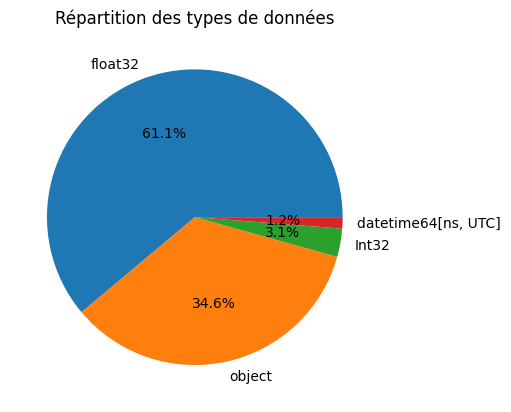

In [77]:
# Répartition du type de variable
compteur_type_variable(data_brut, False, False, True)

## <span style='background:green'>Résumé des données</span>

Quantitatives

In [78]:
# Résumé des variables quantitatives
data_brut.describe(exclude=[np.object_])

,created_t,created_datetime,last_modified_t,last_modified_datetime,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,320749.0,320748,320749.0,320749,248961.0,248961.0,248961.0,2.61136e+05,857.00000,243914.00000,229577.00000,0.0,0.0,1.0,2.00000,4.00000,1.0,1.0,1.0,1.000,0.0,0.0,0.0,1.0,0.0,22823.00000,22859.00000,841.00000,186.00000,33.00000,55.00000,188.00000,149.00000,8.00000,1.000,0.0,21.00000,13.00000,0.0,0.0,0.0,0.0,0.0,143298.00000,144090.00000,243611.00000,244994.00000,72.00000,26.00000,38.00000,...,259929.00000,27.00000,16.00000,9.00000,255533.00000,255486.00000,4133.00000,137554.00000,34.00000,7.07100e+03,1340.00000,9.18000e+02,140867.00000,11154.00000,10815.00000,11719.00000,6784.00000,5240.00000,3042.00000,5.30000e+03,3.07000e+02,2460.00000,3.80000e+01,8.10000e+01,24748.00000,1.58000e+02,141066.00000,5845.00000,140462.00000,6253.00000,3929.00000,2106.00000,1620.00000,79.00000,1.16800e+03,2.00000e+01,1.10000e+01,259.00000,78.00000,29.00000,49.00000,3046.00000,165.00000,948.00000,0.0,268.00000,221233.00000,221233.00000,0.0,0.0
mean,1470622403.13755,2016-08-08 03:29:48.115171584+00:00,1478938315.56608,2016-11-12 08:11:55.566074880+00:00,1.93638,0.01966,0.05525,1.14184e+03,585.50116,12.72937,5.12956,NaN,NaN,7.4,6.04000,36.13618,18.9,8.1,3.0,0.064,NaN,NaN,NaN,61.0,NaN,10.42506,6.31249,3.18210,2.25029,3.61755,0.74229,16.22914,3.82382,0.05700,0.095,NaN,40.19286,25.12308,NaN,NaN,NaN,NaN,NaN,0.07348,0.02007,32.07201,16.00298,11.84167,2.87885,25.89737,...,7.07607,4.65815,2.50625,0.02168,2.02846,0.79875,7.83811,0.00040,0.51872,7.95609e-06,0.05670,3.42193e-02,0.02337,0.32557,0.25901,0.01478,0.02338,0.00690,0.20586,8.93870e-05,1.96282e-02,0.05899,1.31227e-02,1.19052e-01,0.42464,9.26382e-02,0.12517,0.61728,0.00365,0.53414,0.00795,0.02579,0.00301,0.01216,3.12595e-03,1.69017e-03,4.00691e-04,0.00043,1.59456,0.14576,6.42570,31.37662,15.41212,49.54778,NaN,341.70078,9.16474,9.05726,NaN,NaN
min,0.0,2012-01-31 14:43:58+00:00,1332368132.0,2012-03-21 22:15:32+00:00,0.0,0.0,0.0,0.00000e+00,0.00000,0.00000,0.00000,NaN,NaN,7.4,5.88000,0.04473,18.9,8.1,3.0,0.064,NaN,NaN,NaN,61.0,NaN,0.00000,0.00000,0.00000,0.00000,0.05000,0.04100,0.05000,0.09000,0.00700,0.095,NaN,1.00000,1.08000,NaN,NaN,NaN,NaN,NaN,-3.57000,0.00000,0.00000,-17.86000,0.00000,0.00000,0.00000,...,-800.00000,0.92000,0.30000,0.01550,0.00000,0.00000,0.00000,-0.00034,0.00000,0.0000

Qualitatives

_Pas exécuté car la cellule dure > 10 minutes._

In [79]:
# Résumé des variables qualitatives
# data_brut.describe(exclude=[np.number])

## <span style='background:green'>Valeurs manquantes</span>

Valeurs manquantes (Nan) : 39604863 / 51961338 données (76.22 %)
154 / 162 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


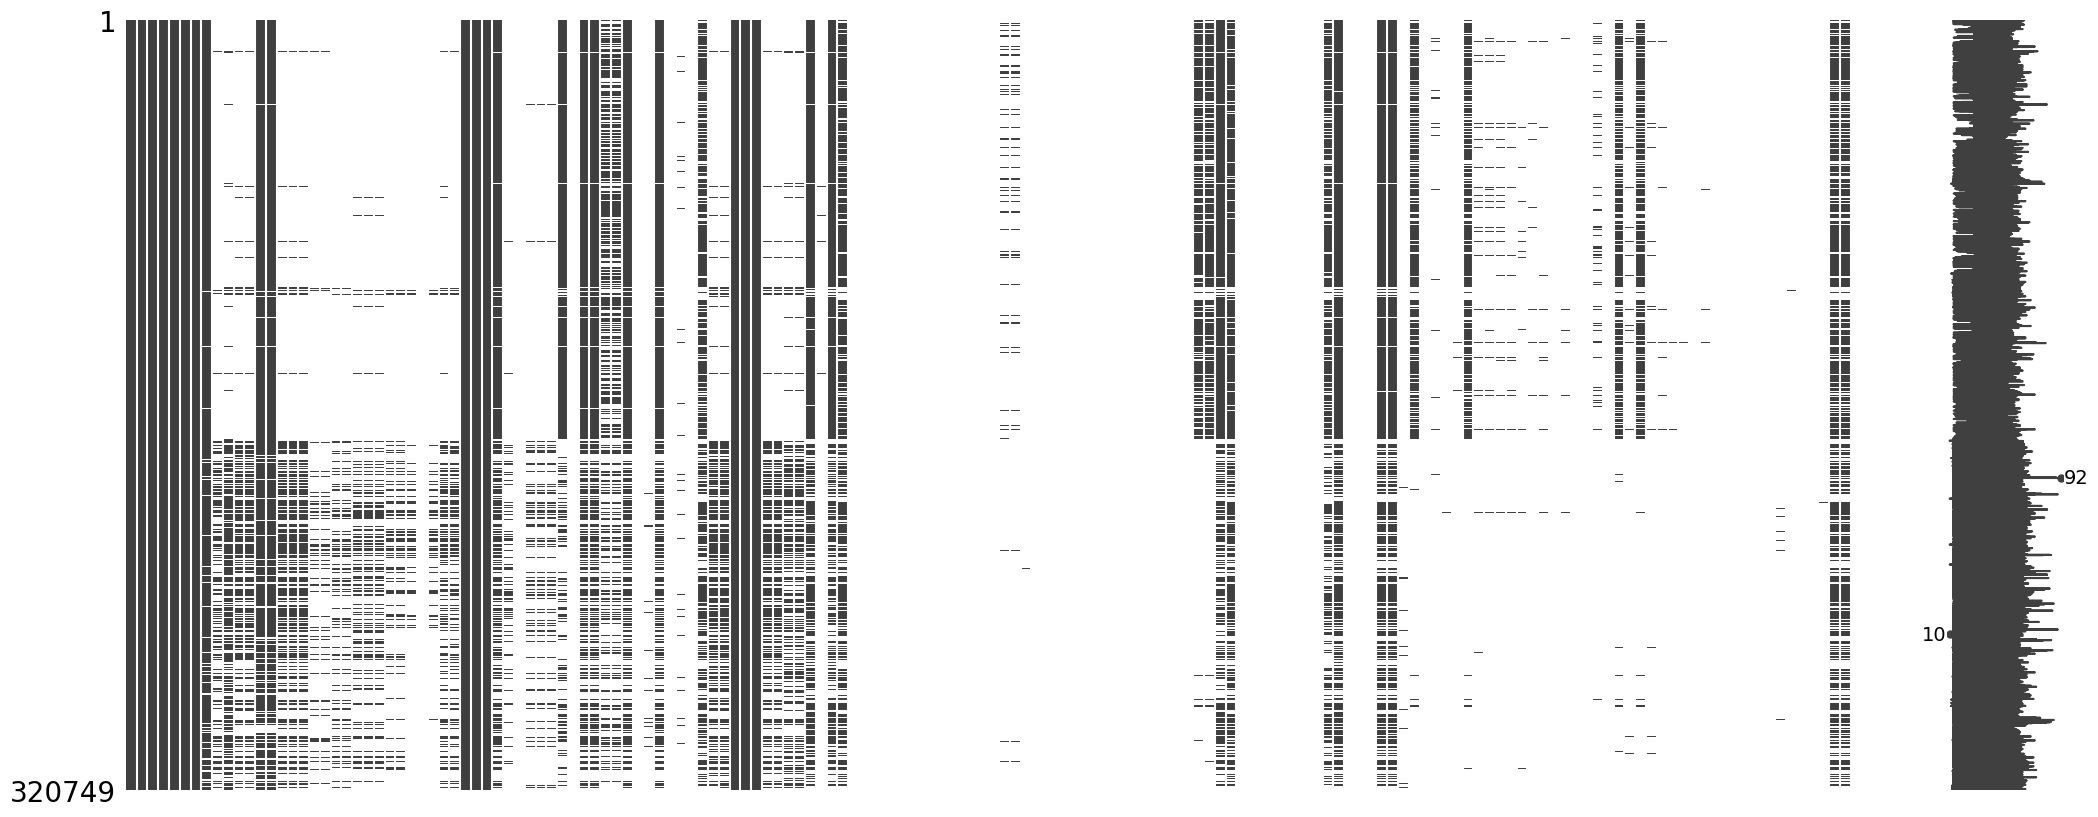

In [80]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(data_brut, False, True)

## <span style='background:green'>Doublons</span>

In [81]:
# Detection des doublons sur la variable du code
first = detect_doublon(data_brut, 'code', 'first')
first = detect_doublon(data_brut, 'code', 'last')
false = detect_doublon(data_brut, 'code', False)

Doublons détecté(s) avec "first" sur "code" : 0
Doublons détecté(s) avec "last" sur "code" : 0
Doublons détecté(s) avec False sur "code" : 0



___
**Bilan sur le jeu de données 'fr.openfoodfacts.org.products.csv'**: 
___
-   Le jeu de données contient **320_749 lignes et 162 colonnes**.
<br><br>
- Le dataset contient des informations sur les aliments : 
  - **temporelle** (*_t) : UNIX timestamp
  - **temporelle** (*_datetime) : date dans le fomat iso8601 (yyyy-mm-ddThh:mn:ssZ)
  - **étiquetage** (*_tags) : étiquette séparée par des virgules
  - **language** (*_fr) : tags en langue française
  - **nutritif** (*_100g) : quantité de nutriment (en g ou en kJ d'énergie) pour 100g ou 100 mL de produit
  - **nutritif** (*_serving) : quantité de nutriment (en g ou en kJ d'énergie) pour l'ingestion d'1 produit
<br><br>
- type de données :
  - **61,1% de nombre décimaux numérique** : 
  - **34,6% de texte**
  - 3,1% d'entier numériques
  - 1,2% de datetime
<br><br>
-   valeurs manquantes : 
    -   39_604_863  de NaN pour 51_961_338  observations (**76.22 %**).
    -   154 / 162 colonnes concernées
<br><br>
-   **Pas de doublons** sur la col 'code'.
<br><br><br>

# <span style='background:blue'>Etape 2 : Nettoyage des données</span>
___

## <span style='background:green'>1/ Filtrage par taux de remplissage</span>

Nous choississons de supprimer les colonnes présentant + de 75% de valeur manquante (NaN) pour garder les colonnes dont le taux de remplissage est > à 25% (au moins une valeur sur 4). 

In [82]:
# Seuil_NaN
seuil_nan = 75

# Affichage graphique des NaN
df_Nan_par_ligne, df_to_supp = filtre_nan_par_seuil(data_brut, seuil_nan, False)

# Suppression col > Seuil_NaN
df_data_clean_nan = data_brut.drop(columns=df_to_supp.index)

# Affichage
print("Voici les colonnes qui vont être supprimées: ")
display(df_to_supp)

affiche_aperçu_df(df_data_clean_nan, "df_data_clean_nan", "des NaN", 2)

Il y a 112 colonnes > 75 % de NaN
Voici les colonnes qui vont être supprimées: 


,nombre,pourcent
packaging_tags,241788.0,75.4
packaging,241789.0,75.4
image_url,244894.0,76.4
image_small_url,244894.0,76.4
purchase_places,262559.0,81.9
generic_name,267976.0,83.5
stores,269035.0,83.9
labels_tags,274105.0,85.5
labels_fr,274105.0,85.5
labels,274190.0,85.5


Voici l'aspect de 'df_data_clean_nan' après nettoyage des NaN


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,brands_tags,categories,categories_tags,categories_fr,countries,countries_tags,countries_fr,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17 09:17:46+00:00,1474103893,2016-09-17 09:18:13+00:00,Farine de blé noir,1kg,Ferme t'y R'nao,[ferme-t-y-r-nao],NaN,<NA>,NaN,en:FR,[en:france],France,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","[en:to-be-completed, en:nutrition-facts-to-be-...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37+00:00,1489069957,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,NaN,<NA>,NaN,<NA>,NaN,US,[en:united-states],États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0,[ bananas -> en:bananas ] [ vegetable-oil -...,<NA>,NaN,0,0,d,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","[en:to-be-completed, en:nutrition-facts-comple...","A compléter,Informations nutritionnelles compl...",NaN,NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.0,0.0,0.0,0.0214,0.0,0.00129,14.0,14.0


320749 ligne(s) x 50 colonne(s)



## <span style='background:green'>2/ Suppression colonnes redondantes</span>

Certaines col/variables dans le dataset sont des variables redondantes. C'est le cas par exemple des variables suffixées par '_tags' ou '_fr' qui ne font que reprendre d'autres variables traduites ou simplifiées.

C'est par exemple de cas des variables 'countries' :

In [83]:
category_columns = ['countries','countries_tags','countries_fr']

df_data_clean_nan[df_data_clean_nan[category_columns].notnull().any(axis=1)][['product_name'] + category_columns].sample(5)

,product_name,countries,countries_tags,countries_fr
91822,Assorted Fruit Snacks,US,[en:united-states],États-Unis
120743,"Napa Valley, Olive Oil, White Truffle",US,[en:united-states],États-Unis
144239,Lollipop Bouquet,US,[en:united-states],États-Unis
144482,Chocolate Silk Pie,US,[en:united-states],États-Unis
66925,"Organic Birch Tree Water, Nettle",US,[en:united-states],États-Unis


On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous souhaitons conserver les variables pour la France (suffixe '*_fr'). Nous allons donc agir de la façon suivante : 
- Suffixe '*_fr' détecté => supprimer la colonne sans le suffixe (si elle existe)
- Suffixe '\*_tags' détecté => supprimer la colonne avec le suffixe '\*_tags'

In [84]:
# Detection des col à supprimer
col_a_supp = filtre_fr_tags(df_data_clean_nan)

10 brands_tags          'Sans suffixe' -> True donc on supprime la variable tags : 'brands_tags'
12 categories_tags      'Sans suffixe' -> True donc on supprime la variable tags : 'categories_tags'
13 categories_fr        'Sans suffixe' -> True donc on supprime la variable pas française : 'categories'
15 countries_tags       'Sans suffixe' -> True donc on supprime la variable tags : 'countries_tags'
16 countries_fr         'Sans suffixe' -> True donc on supprime la variable pas française : 'countries'
21 additives_tags       'Sans suffixe' -> True donc on supprime la variable tags : 'additives_tags'
22 additives_fr         'Sans suffixe' -> True donc on supprime la variable pas française : 'additives'
25 nutrition_grade_fr   'Sans suffixe' -> False donc on supprime la variable pas française : 'nutrition_grade'
29 states_tags          'Sans suffixe' -> True donc on supprime la variable tags : 'states_tags'
30 states_fr            'Sans suffixe' -> True donc on supprime la variable pas f

Les dates également comportent une certaine redondance. Entre les timestamp et les dates au format "yyyy-mm-dd", il est nécessaire d'en éliminer :

In [85]:
category_columns = ['created_t','created_datetime']

df_data_clean_nan[df_data_clean_nan[category_columns].notnull().any(axis=1)][['product_name'] + category_columns].sample(5)

,product_name,created_t,created_datetime
63721,Sprinkles Rainbow,1489062870,2017-03-09 12:34:30+00:00
278138,Pure Premium Orange sans pulpe (format familial),1440078321,2015-08-20 13:45:21+00:00
198653,NaN,1488141715,2017-02-26 20:41:55+00:00
26073,Iceberg Lettuce,1489090501,2017-03-09 20:15:01+00:00
179638,Émincé de poulet,1419614080,2014-12-26 17:14:40+00:00


Si nous regardons le taux de remplissage de ces 2 colonnes, nous pouvons constater qu'elles sont toutes les 2 remplies intégralement. Ce qui suppose que chacune d'elle contient l'intégralité des données. 

<Axes: >

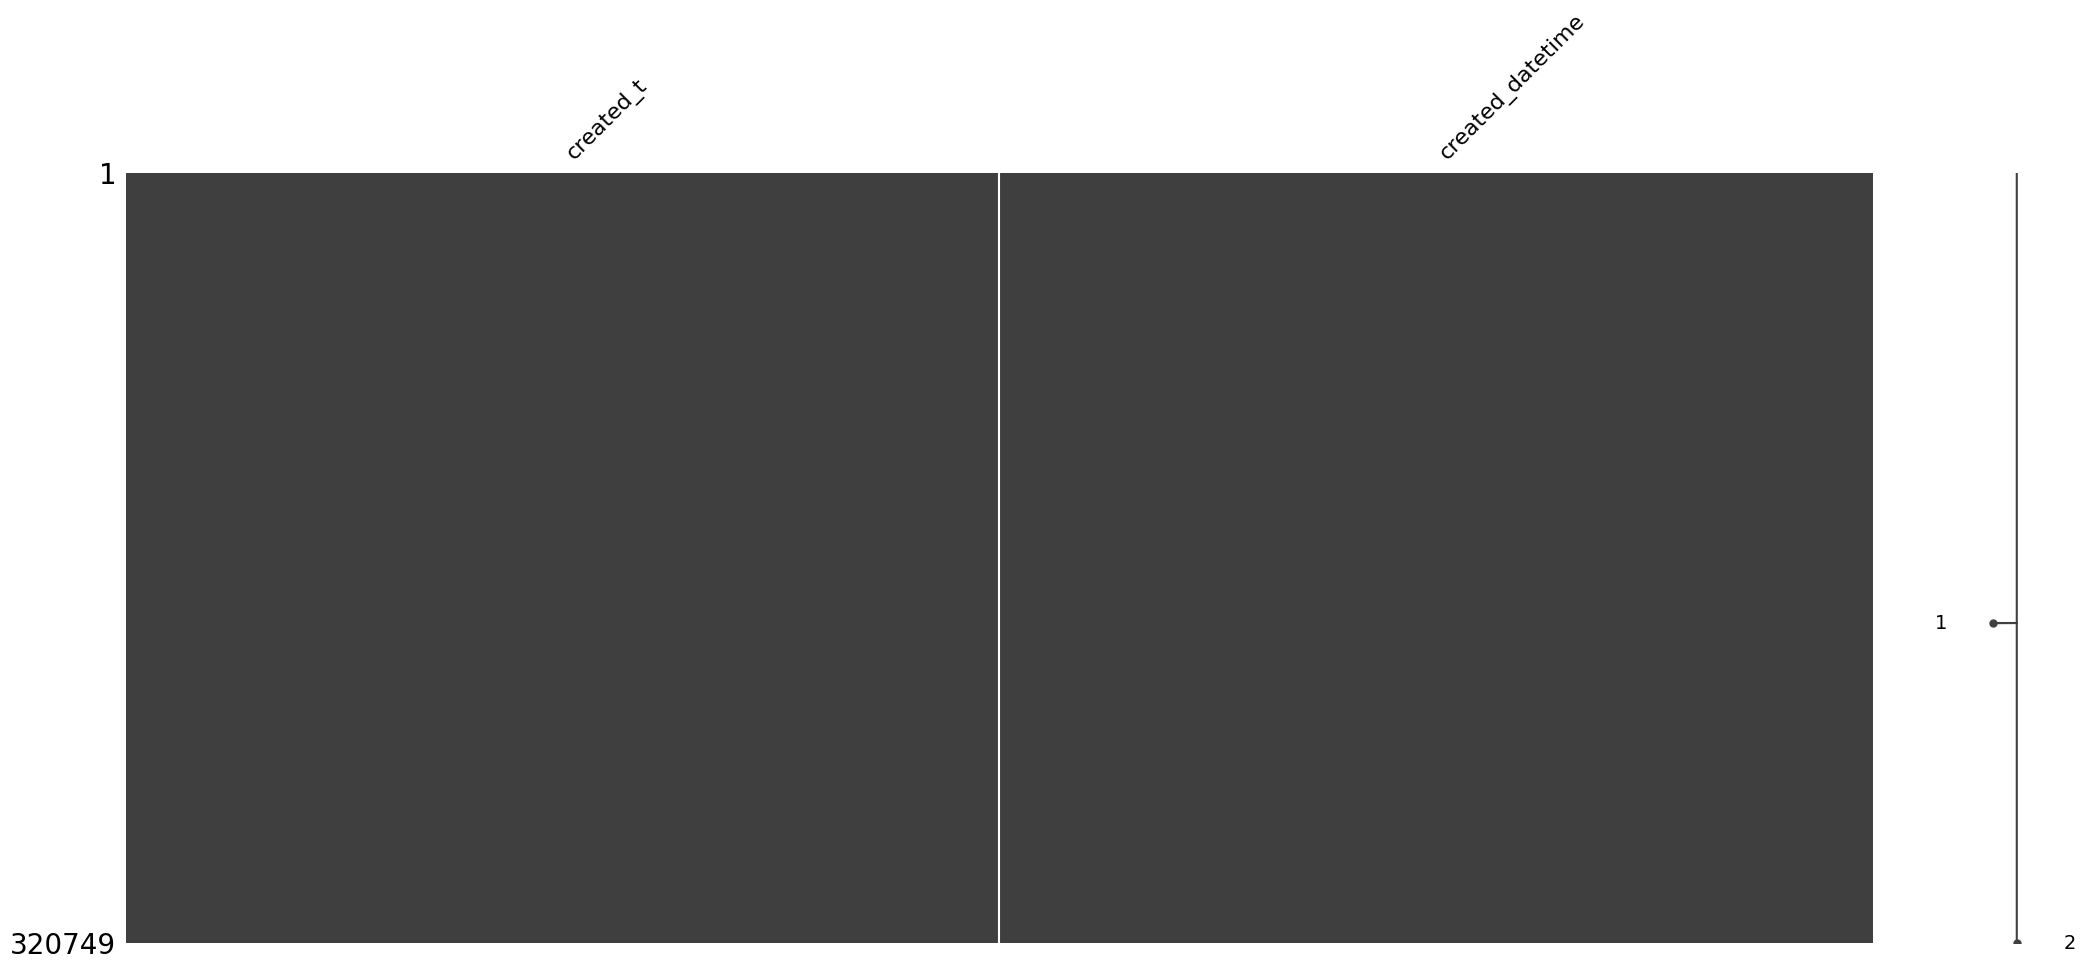

In [86]:
msno.matrix(df_data_clean_nan[category_columns])

Ca ne se voit pas à l'oeil nu mais la date au format UNIX ('created_t') correspond au à la date au format iso8601 ('created_datetime')
<br>Nous allons donc supprimer le format UNIX pour garder uniquement le format iso8601

In [87]:
for col in df_data_clean_nan.columns.values:
    if col.endswith('_t'):
        col_a_supp.append(col)

Nous réalisons la suppression des cols redondantes (sans suffixe, tags et UNIX)

In [88]:
# Suppression col redondantes
df_data_clean_nan_redon = df_data_clean_nan.drop(columns=col_a_supp)

# Affichage
print("Voici les colonnes qui ont été supprimées: ")
display(pd.DataFrame(col_a_supp, columns=["nom_col"]))

affiche_aperçu_df(df_data_clean_nan_redon, "df_data_clean_nan_redon", "des col redondantes", 3)

Voici les colonnes qui ont été supprimées: 


,nom_col
0,brands_tags
1,categories_tags
2,categories
3,countries_tags
4,countries
5,additives_tags
6,additives
7,states_tags
8,states
9,main_category


Voici l'aspect de 'df_data_clean_nan_redon' après nettoyage des col redondantes


,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,1kg,Ferme t'y R'nao,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0,NaN,0,0,d,NaN,NaN,"A compléter,Informations nutritionnelles compl...",NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.000,0.00,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Peanuts,NaN,Torn & Glasser,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0,NaN,0,0,b,NaN,NaN,"A compléter,Informations nutritionnelles compl...",NaN,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.635,0.25,0.0,0.0000,0.071,0.00129,0.0,0.0


320749 ligne(s) x 38 colonne(s)



## <span style='background:green'>3/ Suppression colonnes inutiles</span>

Voici la liste des colonnes restantes dans 'df_data_clean_nan_redon'

In [89]:
for i, col in enumerate(df_data_clean_nan_redon.columns):
    print(i, col)

0 code
1 url
2 creator
3 created_datetime
4 last_modified_datetime
5 product_name
6 quantity
7 brands
8 categories_fr
9 countries_fr
10 ingredients_text
11 serving_size
12 additives_n
13 additives_fr
14 ingredients_from_palm_oil_n
15 ingredients_that_may_be_from_palm_oil_n
16 nutrition_grade_fr
17 pnns_groups_1
18 pnns_groups_2
19 states_fr
20 main_category_fr
21 energy_100g
22 fat_100g
23 saturated-fat_100g
24 trans-fat_100g
25 cholesterol_100g
26 carbohydrates_100g
27 sugars_100g
28 fiber_100g
29 proteins_100g
30 salt_100g
31 sodium_100g
32 vitamin-a_100g
33 vitamin-c_100g
34 calcium_100g
35 iron_100g
36 nutrition-score-fr_100g
37 nutrition-score-uk_100g


Nous allons enlever les col inutiles : url, créateur et cacul du nutriscore pour le Royaume Uni

In [90]:
# Liste des col inutiles
col_inutiles = ["url", "creator", "nutrition-score-uk_100g"]

# Suppression des col inutiles
df_data_clean_nan_redon_utile = df_data_clean_nan_redon.drop(columns=col_inutiles)

# Affichage
print("Voici les colonnes qui ont été supprimées: ")
display(pd.DataFrame(col_inutiles))

affiche_aperçu_df(df_data_clean_nan_redon_utile, "df_data_clean_nan_redon_utile", "des col inutiles", 3)

Voici les colonnes qui ont été supprimées: 


,0
0,url
1,creator
2,nutrition-score-uk_100g


Voici l'aspect de 'df_data_clean_nan_redon_utile' après nettoyage des col inutiles


,code,created_datetime,last_modified_datetime,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,1kg,Ferme t'y R'nao,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0,NaN,0,0,d,NaN,NaN,"A compléter,Informations nutritionnelles compl...",NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.000,0.00,0.0,0.0214,0.000,0.00129,14.0
2,0000000004559,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Peanuts,NaN,Torn & Glasser,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0,NaN,0,0,b,NaN,NaN,"A compléter,Informations nutritionnelles compl...",NaN,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.635,0.25,0.0,0.0000,0.071,0.00129,0.0


320749 ligne(s) x 35 colonne(s)



## <span style='background:green'>3/ Conservation des produis disponibles en France</span>

Tout d'abord, nous allons regarder le nombre de valeur manquante dans la colonne des pays

In [91]:
nan_pays_pourcent = df_Nan_par_ligne.loc["countries_fr"]["pourcent"]
print("{0} % de valeurs manquantes dans la col des pays".format(nan_pays_pourcent))

0.1 % de valeurs manquantes dans la col des pays


Nous allons regarder les pays présent dans le dataset

In [92]:
pays_unique = df_data_clean_nan_redon_utile["countries_fr"].unique()
df_pays_unique = pd.DataFrame(pays_unique, columns=["pays"])

print("Il y a", df_pays_unique.shape[0], "pays différents dans le dataset 'df_data_clean_nan_redon_utile'")
display(pd.DataFrame(df_pays_unique).head(15))

Il y a 718 pays différents dans le dataset 'df_data_clean_nan_redon_utile'


,pays
0,France
1,États-Unis
2,Royaume-Uni
3,"France,États-Unis"
4,Canada
5,Suisse
6,Espagne
7,Allemagne
8,Slovénie
9,Italie


Or nous remarquons que plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte avec une virgule pour visualiser tous nos pays :

In [93]:
pays_virgule = split_nom_pays(df_data_clean_nan_redon_utile, col='countries_fr', sep=",")

df_pays_virgule = pd.DataFrame(pays_virgule, columns=["pays"])

display(df_pays_virgule.head(5))

,pays
0,France
1,États-Unis
2,États-Unis
3,États-Unis
4,États-Unis


Mais si on affiche toutes les noms de pays ainsi trouvé, on peut voir qu'il y a encore des noms pays non conventionnels 

In [94]:
pays_virgule_unique = df_pays_virgule["pays"].unique()
df_pays_virgule_unique = pd.DataFrame(pays_virgule_unique, columns=['pays']).sort_values(by="pays").reset_index(drop=True)

print("Il y a", df_pays_virgule_unique.shape[0], "pays différents après le split par la virgule")
display(df_pays_virgule_unique)

Il y a 266 pays différents après le split par la virgule


,pays
0,77-provins
1,Afrique du Sud
2,Aix-en-provence
3,Albanie
4,Algérie
5,Allemagne
6,Andorre
7,Angola
8,Arabie saoudite
9,Argentine


On remarque qu'il y a plusieurs problèmes d'écriture des pays sur certaines lignes :
- Des villes, des régions et des départements français (parfois avec le numéro de département)
- Le pays est écrit en anglais, allemand, néerlandais, chinois, arabe, hongrois, portugais, japonais, russe, thaï, indi
- Le monde entier est nommé dans différentes langues (Worldwide, Weltweit, Global-market)
- Il y a écrit des préfixes avec ':' devant le pays relatif à des pays (de:, en:, es:, nl:, xx:)
- Il y a des pays avec des accents sur la première lettre du pays (qui est une voyelle)

Nous effectuons un split du texte avec ':' pour récupérer les pays qui ont ce problème :

In [95]:
pays_2p = split_nom_pays(df_pays_virgule_unique, col='pays', sep=":")

df_pays_2p = pd.DataFrame(pays_2p, columns=["pays"])

print("Il y a", df_pays_2p.shape[0], "pays après le split par ':'")

Il y a 266 pays après le split par ':'


Nous ne garderons pas les pays qui sont des villes ou région française car elles ne représente pas l'intégralité de la France.


Nous allons conserver tous les noms de pays qui concernent : 
- La France
- Le monde entier

Nous ferons cela dans toutes les langues trouvées

In [96]:
# FRANCE 
# en anglais, allemand, néerlandais, chinois, arabe, hongrois, portugais, japonais, russe, thaï, indi
noms_france = ["France", "Frankreich", "Frankrijk", "法国", "فرنس", "Franciaország", "França", "フランス", "Франция", "ฝรั่งเศส", "फ़्रांस"]

# MONDE ENTIER
monde_list = ["Union européenne", "Weltweit", "Worldwide", "Global-market", "All-over-the-world", "World"]

# Conservation des mots des 2 listes trouvées dans le df (trié)
df_france_et_monde = df_pays_2p[df_pays_2p["pays"].isin(noms_france + monde_list)].sort_values(by="pays")

# Affichage des valeurs différentes pour la France
france_unique = df_france_et_monde["pays"].unique()
df_france = pd.DataFrame(france_unique, columns=["pays"])

print("Voici les noms relatifs à la France trouvés dans 'df_pays_2p' : ")
display(df_france)

Voici les noms relatifs à la France trouvés dans 'df_pays_2p' : 


,pays
0,All-over-the-world
1,France
2,Frankreich
3,Frankrijk
4,Global-market
5,Union européenne
6,Weltweit
7,World
8,Worldwide


Nous allons filtrer le df des données en extrayant uniquement les lignes où le pays est un de ces termes en lien avec la France ou le monde

In [97]:
# Filtrer les lignes en lien avec la France
df_data_clean_france = df_data_clean_nan_redon_utile[df_data_clean_nan_redon_utile['countries_fr'].isin(df_france["pays"])].reset_index(drop=True)

# Affichage
affiche_aperçu_df(df_data_clean_france, "df_data_clean_france", "des pays monde et France", 3)

Voici l'aspect de 'df_data_clean_france' après nettoyage des pays monde et France


,code,created_datetime,last_modified_datetime,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,1kg,Ferme t'y R'nao,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000024600,2015-06-17 08:45:04+00:00,2015-06-17 10:11:54+00:00,Filet de bœuf,2.46 kg,NaN,Filet-de-boeuf,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,unknown,unknown,"A compléter,Informations nutritionnelles à com...",Filet-de-boeuf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000027205,2016-03-17 18:17:10+00:00,2016-03-17 18:17:18+00:00,NaN,NaN,NaN,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


94461 ligne(s) x 35 colonne(s)



## <span style='background:green'>5/ Filtrage valeur abérrantes</span>

Toutes les colonnes qui ont un nom qui termine par '_100g' sont des float

In [98]:
# Trie des col qui se termine par '_100g'
colonnes_100g = df_data_clean_france[[col for col in df_data_clean_france.columns if col.endswith('_100g')]]

# Répartition du type de variable par col
compteur_type_variable(colonnes_100g, True, False, False)

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables



energy_100g                float32
fat_100g                   float32
saturated-fat_100g         float32
trans-fat_100g             float32
cholesterol_100g           float32
carbohydrates_100g         float32
sugars_100g                float32
fiber_100g                 float32
proteins_100g              float32
salt_100g                  float32
sodium_100g                float32
vitamin-a_100g             float32
vitamin-c_100g             float32
calcium_100g               float32
iron_100g                  float32
nutrition-score-fr_100g    float32
dtype: object

Nous allons travailler sur une copie du dataframe

In [99]:
# Nom des colonnes '_100g' dans une liste
colonnes_100g_list = colonnes_100g.columns.values.tolist()

# df de travail est une copie des colonnes '_100g'
df_travail = df_data_clean_france.loc[:, colonnes_100g_list].copy()
display(df_travail.head(3))

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous allons d'abord observer un aperçu des statistiques de chacune des colonnes de ce dataframe de travail 

In [100]:
df_travail.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,6.14710e+04,44628.00000,59427.00000,211.00000,249.00000,44216.00000,59524.00000,43665.00000,61220.00000,59581.00000,59578.00000,422.00000,1086.00000,1926.00000,915.00000,58537.00000
mean,1.16773e+03,13.27160,5.38371,0.33391,0.06035,27.30007,13.23362,2.52232,7.79231,1.16071,0.45700,0.00081,0.14638,0.34013,0.05125,8.59783
std,1.31566e+04,16.98278,8.53676,1.30442,0.69087,27.30501,19.02528,4.63301,7.92944,4.29003,1.68897,0.00658,3.05998,1.86357,0.85138,9.01725
min,0.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000,-0.10000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-15.00000
25%,4.26000e+02,1.30000,0.30000,0.00000,0.00000,4.00000,1.00000,0.00000,1.80000,0.08000,0.03150,0.00012,0.01200,0.12000,0.00267,1.00000
50%,1.02600e+03,6.80000,1.90000,0.03000,0.00000,14.00000,4.00000,1.30000,6.00000,0.57000,0.22441,0.00016,0.02000,0.13500,0.00580,8.00000
75%,1.63950e+03,21.00000,7.30000,0.30000,0.01250,52.60000,17.00000,3.20000,11.00000,1.25000,0.49213,0.00056,0.03000,0.33925,0.00800,15.00000
max,3.25137e+06,380.00000,210.00000,17.20000,10.90000,190.00000,105.00000,178.00000,100.00000,211.00000,83.00000,0.12000,100.00000,69.50000,25.00000,40.00000


Nous observons des incohérences dans ces statistiques. Les valeurs maximales de plusieurs colonnes d'ingrédient sont > 100 alors que cela ne devrait pas être le cas. Nous allons donc appliquer des règles métier pour mettre de l'ordre dans tout cela. 


## Energie

Visualisons les outliers de 'energy_100g'

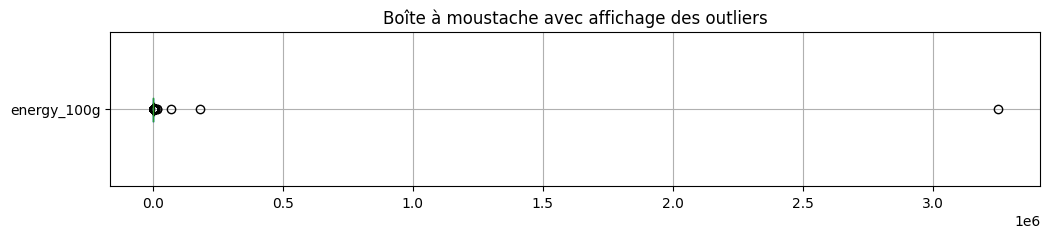

In [101]:
# Affichage des boites à moustache
boite_moustache_100g(df_travail, col="energy_100g")


Il faut savoir que les lipides sont la plus grande source de kcal par gramme ingéré, à raison de 9 kcal/g. Or 1 kcal = 4,18 Joules

Donc l'ingestion de 100g de lipides = 900 kcal = 3_762 J.

=> **L'energie par 100g doit être compris entre 0 et 3_762 J** 

Source : [Valeur énergétique sur Wikipedia](https://fr.wikipedia.org/wiki/Valeur_%C3%A9nerg%C3%A9tique)

Source : [Information nutritionnelle sur Wikipedia](https://fr.wikipedia.org/wiki/Information_nutritionnelle)

In [102]:
# Filtrage selon regle métier
df_travail = regle_metier_borne(df_travail, "energy_100g", borne_min=0, borne_max=3_762)

Nombre de valeurs en dehors de la plage [0 - 3762] avant remplacement :  236
Nombre de valeurs en dehors de la plage [0 - 3762] après remplacement :  0


Nous avons remplacé les 236 valeurs hors des bornes par des NaN.

Nous vérifions la suppression des outliers : 

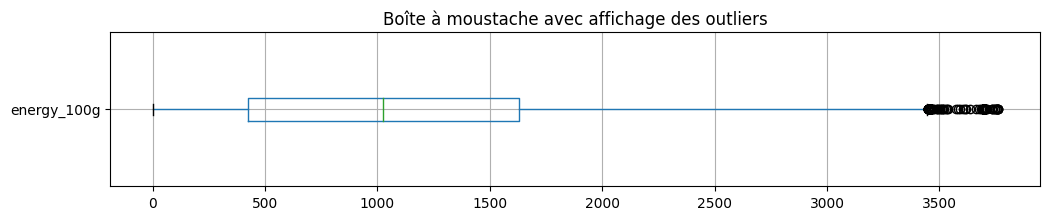

In [103]:
# Affichage des boites à moustache
boite_moustache_100g(df_travail, col="energy_100g")

Il y a toujours des outliers mais je pars du principe qu'elles sont atypiques mais pas abérrantes car elles sont possibles dans la plage [0 - 3762] Joules

## Nutriment

Les nutriments sont toutes les colonnes '_100g' à l'exception des valeurs d'énergie, de ph, d'impact carbone et de score nutritionnel. Nous allons donc travailler que sur les colonnes des nutriments. 

In [104]:
col_pas_nutriment = ["energy_100g", "energy-kj_100g", "energy-kcal_100g",
                    "ph_100g",
                    "carbon-footprint_100g",
                    "nutrition-score-fr_100g"]

# Isolement des col de nutriment
df_nutriment = df_travail.loc[:, ~df_travail.columns.isin(col_pas_nutriment)]
col_nutriment_list = df_nutriment.columns.tolist()

# Affichage
print("Les colonnes des nutriments sont :")
display(col_nutriment_list)

Les colonnes des nutriments sont :


['fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

Visualisons les outliers des nutriments

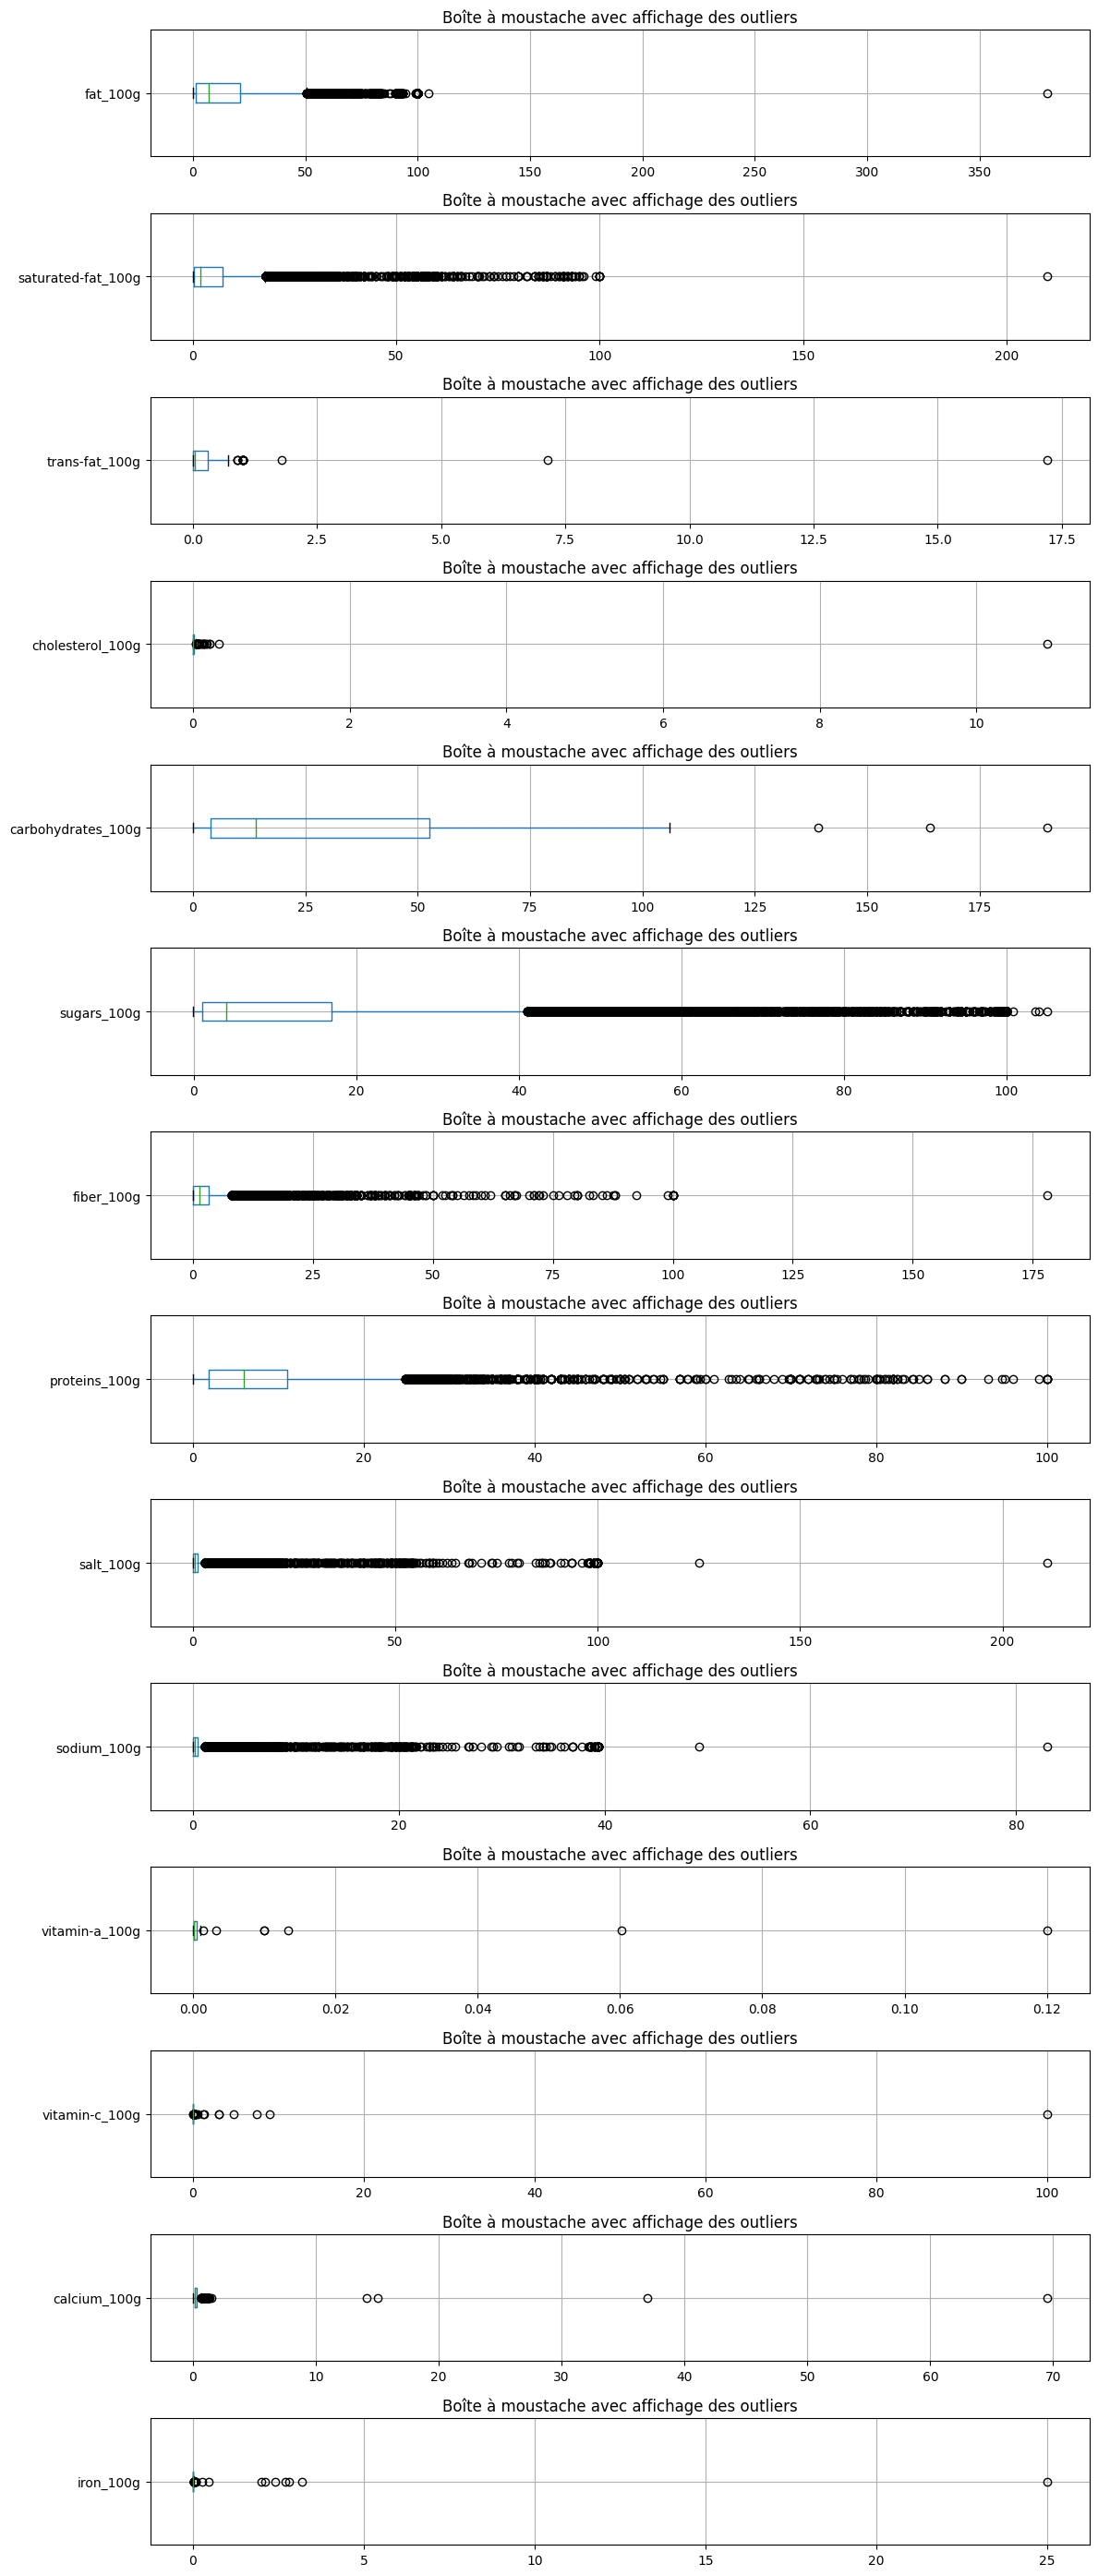

In [105]:
# Affichage des boites à moustache
boite_moustache_100g(df_nutriment)



La quantité en gramme affichée de nutriment ne peut pas dépassé la quantité de produit total. 

=> **La quantité de nutriment par 100g doit être compris entre 0 et 100g**

In [106]:
display(df_nutriment.head(3))
df_nutriment.shape

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(94461, 14)

In [107]:
# POUR chaque colonne de nutriment
for col in col_nutriment_list:
    print("\n", col)
    
    # Filtrage selon regle métier
    df_nutriment = regle_metier_borne(df_nutriment, col, borne_min=0, borne_max=100)


 fat_100g
Nombre de valeurs en dehors de la plage [0 - 100] avant remplacement :  2
Nombre de valeurs en dehors de la plage [0 - 100] après remplacement :  0

 saturated-fat_100g
Nombre de valeurs en dehors de la plage [0 - 100] avant remplacement :  1
Nombre de valeurs en dehors de la plage [0 - 100] après remplacement :  0

 trans-fat_100g
Nombre de valeurs en dehors de la plage [0 - 100] avant remplacement :  0
Nombre de valeurs en dehors de la plage [0 - 100] après remplacement :  0

 cholesterol_100g
Nombre de valeurs en dehors de la plage [0 - 100] avant remplacement :  0
Nombre de valeurs en dehors de la plage [0 - 100] après remplacement :  0

 carbohydrates_100g
Nombre de valeurs en dehors de la plage [0 - 100] avant remplacement :  8
Nombre de valeurs en dehors de la plage [0 - 100] après remplacement :  0

 sugars_100g
Nombre de valeurs en dehors de la plage [0 - 100] avant remplacement :  5
Nombre de valeurs en dehors de la plage [0 - 100] après remplacement :  0

 fiber_1

C:\Users\pierr\AppData\Local\Temp\ipykernel_14964\2403622355.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].mask((df[col] < borne_min) | (df[col] > borne_max), np.nan)


Nous avons remplacé toutes les valeurs hors des bornes par des NaN.

Nous vérifions la suppression des outliers : 

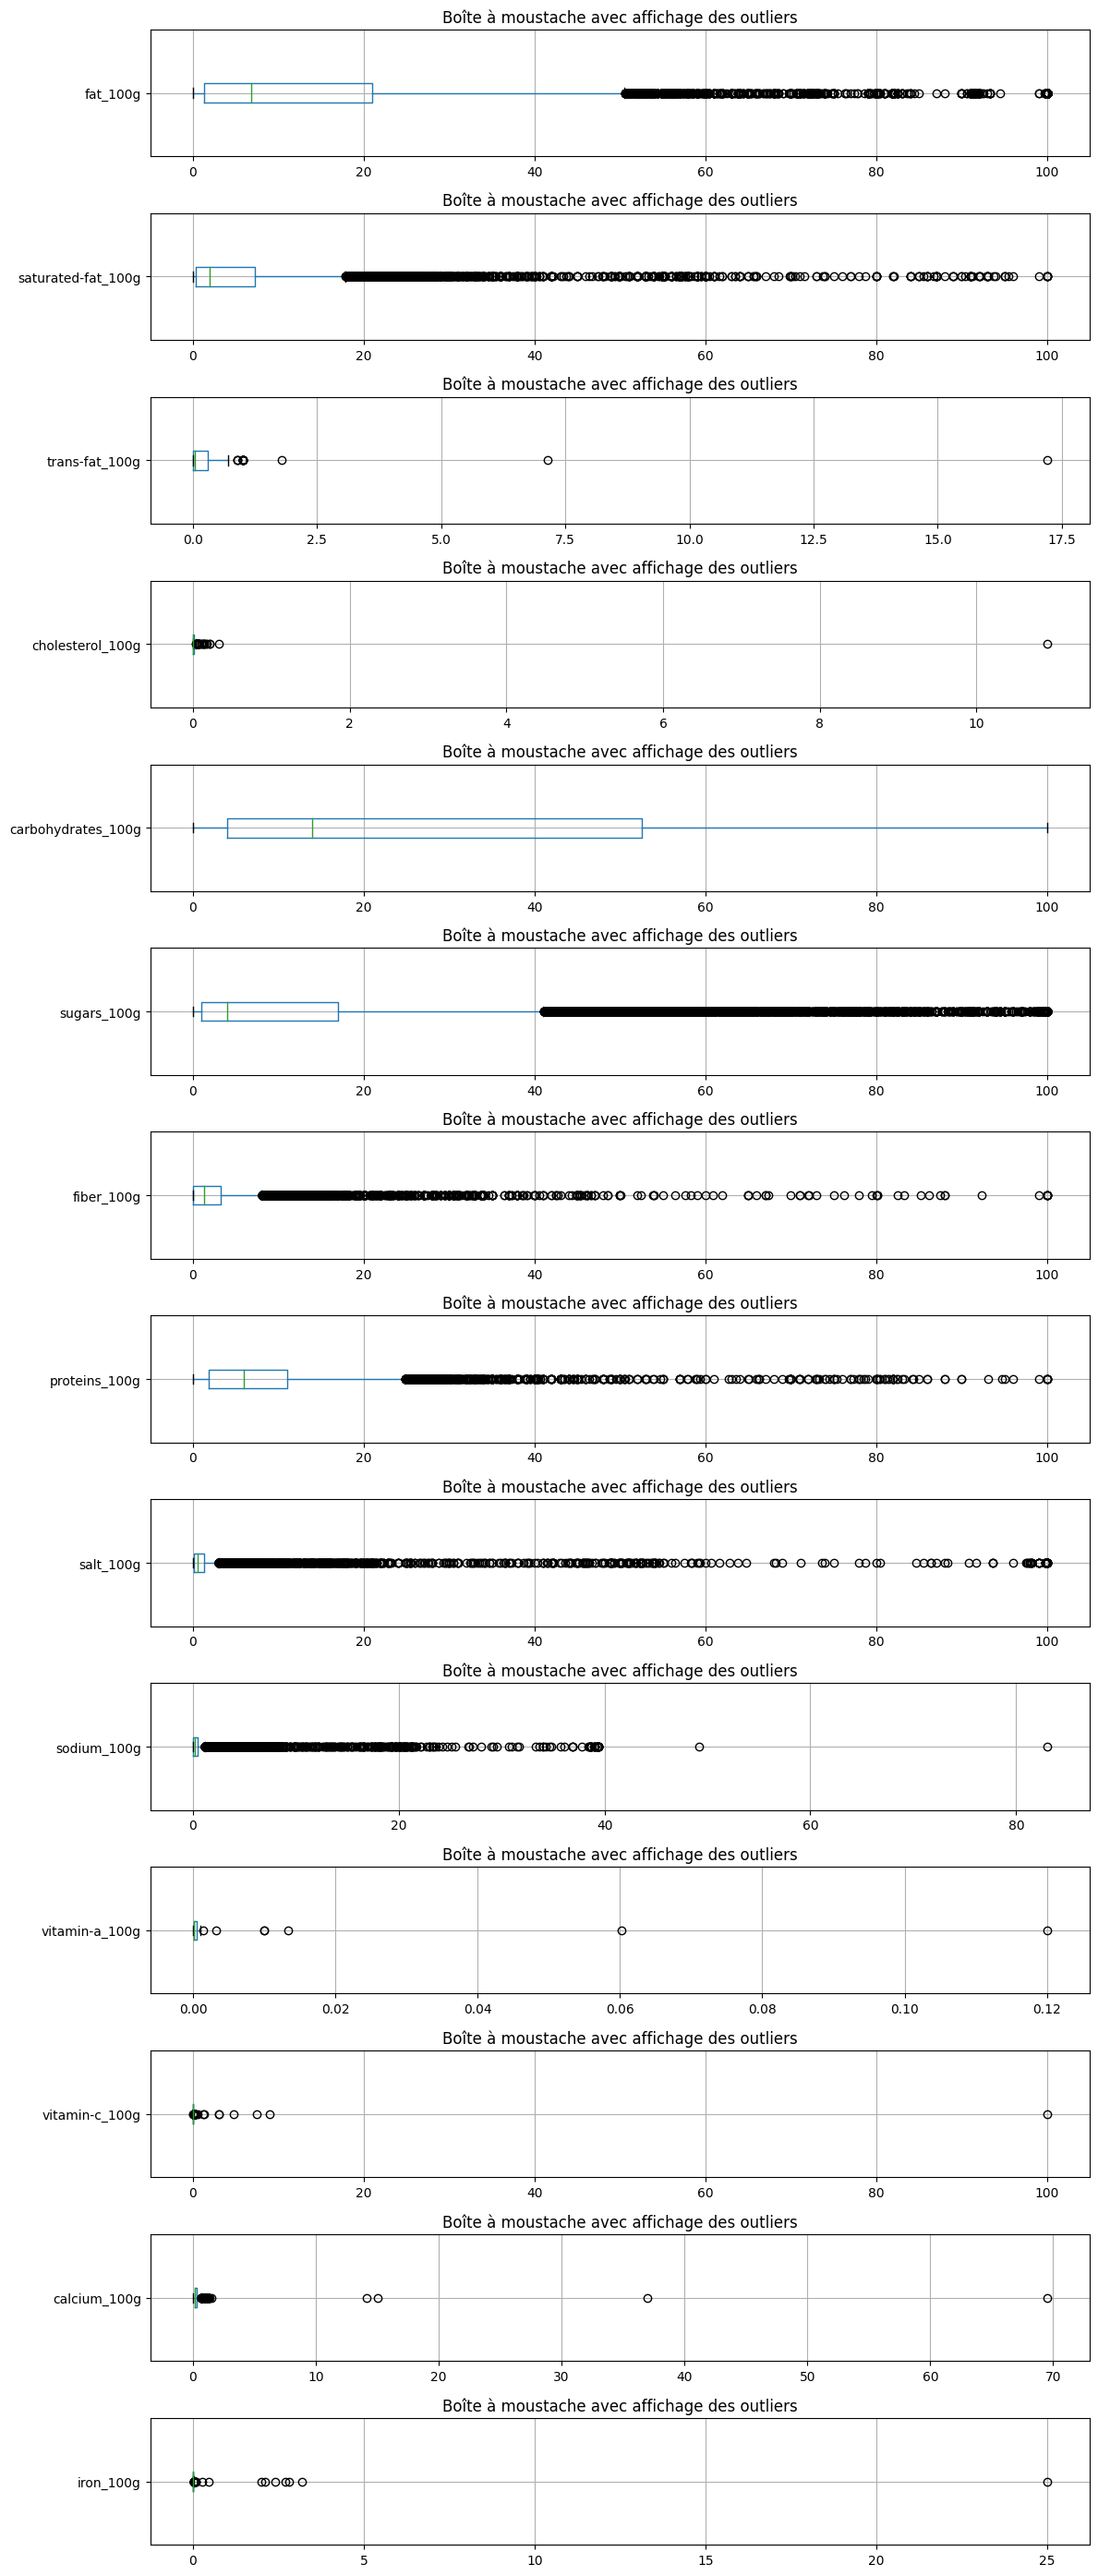

In [108]:
# Affichage des boites à moustache
boite_moustache_100g(df_nutriment)

 ## Sous-Nutriment
 
 Egalement certains nutriments sont des 'sous-nutriments' inclus dans d'autres nutriment comme :
- 'graisses saturées' et 'graisses trans' font parties de 'lipide'
- 'sucre' fait parti de 'glucide'
  

=> **La quantité de 'sous-nutriment' par 100g doit être < à celle du nutriment auquel il appartient** 

Source : [Information nutritionnelle sur Wikipedia](https://fr.wikipedia.org/wiki/Information_nutritionnelle)


In [109]:
# Dictionnaire arborescence graisse et glucide
dico_sous_nutriment = {
    "fat_100g" : ["saturated-fat_100g", "trans-fat_100g"], 
    "carbohydrates_100g" : ["sugars_100g"]
    }

# Détection et remplacement des valeurs des sous-nutriments trop grandes
df_nutriment = regle_metier_sous_nutriment(dico_sous_nutriment, df_nutriment, replace=True)


Ligne 980 
 valeur 'saturated-fat_100g' = 0.1 
 valeur 'fat_100g' = 0.0
=> modification effectuée

Ligne 3751 
 valeur 'saturated-fat_100g' = 73.8 
 valeur 'fat_100g' = 54.79999923706055
=> modification effectuée

Ligne 3981 
 valeur 'saturated-fat_100g' = 23.1 
 valeur 'fat_100g' = 23.0
=> modification effectuée

Ligne 4035 
 valeur 'saturated-fat_100g' = 14.5 
 valeur 'fat_100g' = 9.9399995803833
=> modification effectuée

Ligne 8169 
 valeur 'saturated-fat_100g' = 0.5 
 valeur 'fat_100g' = 0.0
=> modification effectuée

Ligne 10395 
 valeur 'saturated-fat_100g' = 0.5 
 valeur 'fat_100g' = 0.0
=> modification effectuée

Ligne 15261 
 valeur 'saturated-fat_100g' = 0.8 
 valeur 'fat_100g' = 0.6000000238418579
=> modification effectuée

Ligne 15272 
 valeur 'saturated-fat_100g' = 0.8 
 valeur 'fat_100g' = 0.6000000238418579
=> modification effectuée

Ligne 15279 
 valeur 'saturated-fat_100g' = 0.1 
 valeur 'fat_100g' = 0.0
=> modification effectuée

Ligne 15322 
 valeur 'saturated-fat_

Nous re-integrons les valeurs du dataframe de nutriment dans le dataframe de travail

In [110]:
# Remplacez les colonnes dans df_data_clean_france par celles de df_travail
df_travail[df_nutriment.columns] = df_nutriment

## Nutri-score
Visualisons les outliers de 'nutrition-score-fr_100g'



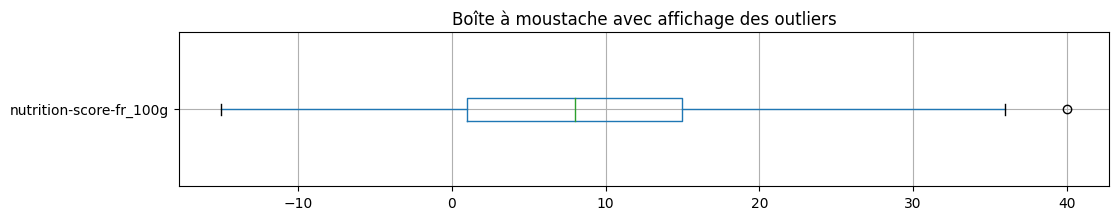

In [111]:
# Affichage des boites à moustache
boite_moustache_100g(df_travail, col="nutrition-score-fr_100g")


Le Nutri-Score est une échelle graphique qui scinde le **score nutritionnel** en 5 classes (exprimées
par une couleur associée à une lettre) et vise à faciliter la visibilité, la lisibilité, et la compréhension
de la valeur nutritionnelle par le consommateur.

Le **score nutritionnel** est calculé à l’aide de la déclaration nutritionnelle pour 100g ou 100 mL de produits tel
que vendu (sauf exceptions) et de la liste des ingrédients. Les points sont attribués en fonction de la teneur
des éléments suivants :

- Eléments « défavorables », dont l’excès est considéré comme délétère pour la santé : l’énergie en
kJ, les sucres, le sel et les acides gras saturés (et les édulcorants non-nutritifs pour l’algorithme
adapté aux boissons)<br><br>
- Eléments « favorables » : protéines, fibres, fruits, légumes et légumes secs (huiles de noix, colza et
d’olives pour la méthode de calcul datant de 2017).

=> **Le score nutritionnel en France doit être compris entre -15 et +40** 

Source : [NUTRI-SCORE Questions & Réponses de Santé publique France](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjqxJ7p8KyBAxXDUqQEHRpiBeoQFnoECBUQAQ&url=https%3A%2F%2Fwww.santepubliquefrance.fr%2Fmedia%2Ffiles%2F02-determinants-de-sante%2Fnutrition-et-activite-physique%2Fnutri-score%2Ffaq_fr&usg=AOvVaw0WQv0l_eVKgvmWEjnUAVZC&opi=89978449)

In [112]:
# Filtrage selon regle métier
df_travail = regle_metier_borne(df_travail, "nutrition-score-fr_100g", borne_min=-15, borne_max=40)

Nombre de valeurs en dehors de la plage [-15 - 40] avant remplacement :  0
Nombre de valeurs en dehors de la plage [-15 - 40] après remplacement :  0


Il n'y avait pas d'outliers dans la colonne "nutrition-score-fr_100g"

Nous vérifions les statistiques de chacune des colonnes de ce dataframe de travail 

In [113]:
df_travail.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,61235.00000,44626.00000,59426.00000,211.00000,249.00000,44208.00000,59519.00000,43664.00000,61220.00000,59579.00000,59578.00000,422.00000,1086.00000,1926.00000,915.00000,58537.00000
mean,1098.30688,13.26133,5.37791,0.33391,0.06035,27.28211,13.22358,2.51830,7.79231,1.15511,0.45700,0.00081,0.14638,0.34013,0.05125,8.59783
std,761.25897,16.88861,8.49201,1.30442,0.69087,27.27143,19.00852,4.55631,7.92944,4.17235,1.68897,0.00658,3.05998,1.86357,0.85138,9.01725
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-15.00000
25%,423.00000,1.30000,0.30000,0.00000,0.00000,4.00000,1.00000,0.00000,1.80000,0.08000,0.03150,0.00012,0.01200,0.12000,0.00267,1.00000
50%,1023.00000,6.80000,1.90000,0.03000,0.00000,14.00000,4.00000,1.30000,6.00000,0.57000,0.22441,0.00016,0.02000,0.13500,0.00580,8.00000
75%,1632.00000,21.00000,7.30000,0.30000,0.01250,52.60000,17.00000,3.20000,11.00000,1.25000,0.49213,0.00056,0.03000,0.33925,0.00800,15.00000
max,3761.00000,100.00000,100.00000,17.20000,10.90000,100.00000,100.00000,100.00000,100.00000,100.00000,83.00000,0.12000,100.00000,69.50000,25.00000,40.00000


Après ces opérations de nettoyage, les valeurs médianes, d'écarts-type, de minimum et maximum sont plus cohérentes. Nous allons pouvoir exploiter ces données pour estimer les valeurs manquantes

Nous re-integrons les valeurs du dataframe de travail dans le dataframe des données

In [161]:
# Remplacez les colonnes dans df_data_clean_france par celles de df_travail
df_data_clean_france[df_travail.columns] = df_travail

## <span style='background:green'>6/ Imputation valeurs manquantes par produit</span>

### Colonnes essentielles

Nous allons d'abord vérifier qu'il n'y a aucune valeur manquante sur les colonnes essentielles :
 - Code barre
 - Nom du produit
 - Pays

In [205]:
# Liste des col essentielles
col_essentiel_list = ["code", "product_name", "countries_fr"]

# Sélectionnez uniquement les colonnes essentielles et vérifiez les valeurs manquantes
nan_col_essentiel = df_data_clean_france[col_essentiel_list].isna()

# Comptez les valeurs manquantes par colonne
nan_col_essentiel_resume = nan_col_essentiel.sum()

# Affichez le résumé
print(nan_col_essentiel_resume)


code               0
product_name    6997
countries_fr       0
dtype: int64


Nous remarquons qu'il manque 6_997 nom de produit. Nous allons supprimer les lignes de ces produits. 

In [206]:
# Supprimez les lignes avec des valeurs NaN
df_data_clean_essentiel = df_data_clean_france.dropna(subset=["product_name"])

# Calcul nombre de lignes supprimées
diff = df_data_clean_france.shape[0] - df_data_clean_essentiel.shape[0]
print("{0} lignes ont été enlevées\n".format(diff))

# Affichage
affiche_aperçu_df(df_data_clean_essentiel, "df_data_clean_france", "des colonnes essentielles", 3)

6997 lignes ont été enlevées

Voici l'aspect de 'df_data_clean_france' après nettoyage des colonnes essentielles


,code,created_datetime,last_modified_datetime,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,1kg,Ferme t'y R'nao,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000024600,2015-06-17 08:45:04+00:00,2015-06-17 10:11:54+00:00,Filet de bœuf,2.46 kg,NaN,Filet-de-boeuf,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,unknown,unknown,"A compléter,Informations nutritionnelles à com...",Filet-de-boeuf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000039259,2015-01-25 21:36:13+00:00,2016-09-10 20:08:02+00:00,Twix x2,NaN,NaN,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,unknown,unknown,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


87464 ligne(s) x 35 colonne(s)



On fait un point sur les valeurs manquantes sur tout le dataframe 'df_data_clean_essentiel'

Valeurs manquantes (Nan) : 578282 / 3061240 données (18.89 %)
18 / 35 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
brands,5745,6.570000
quantity,20065,22.940000
pnns_groups_2,25091,28.690000
energy_100g,26544,30.350000
proteins_100g,26559,30.370000
pnns_groups_1,27018,30.890000
salt_100g,28191,32.230000
sugars_100g,28253,32.300000
saturated-fat_100g,28339,32.400000
main_category_fr,29122,33.300000


18 / 35 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


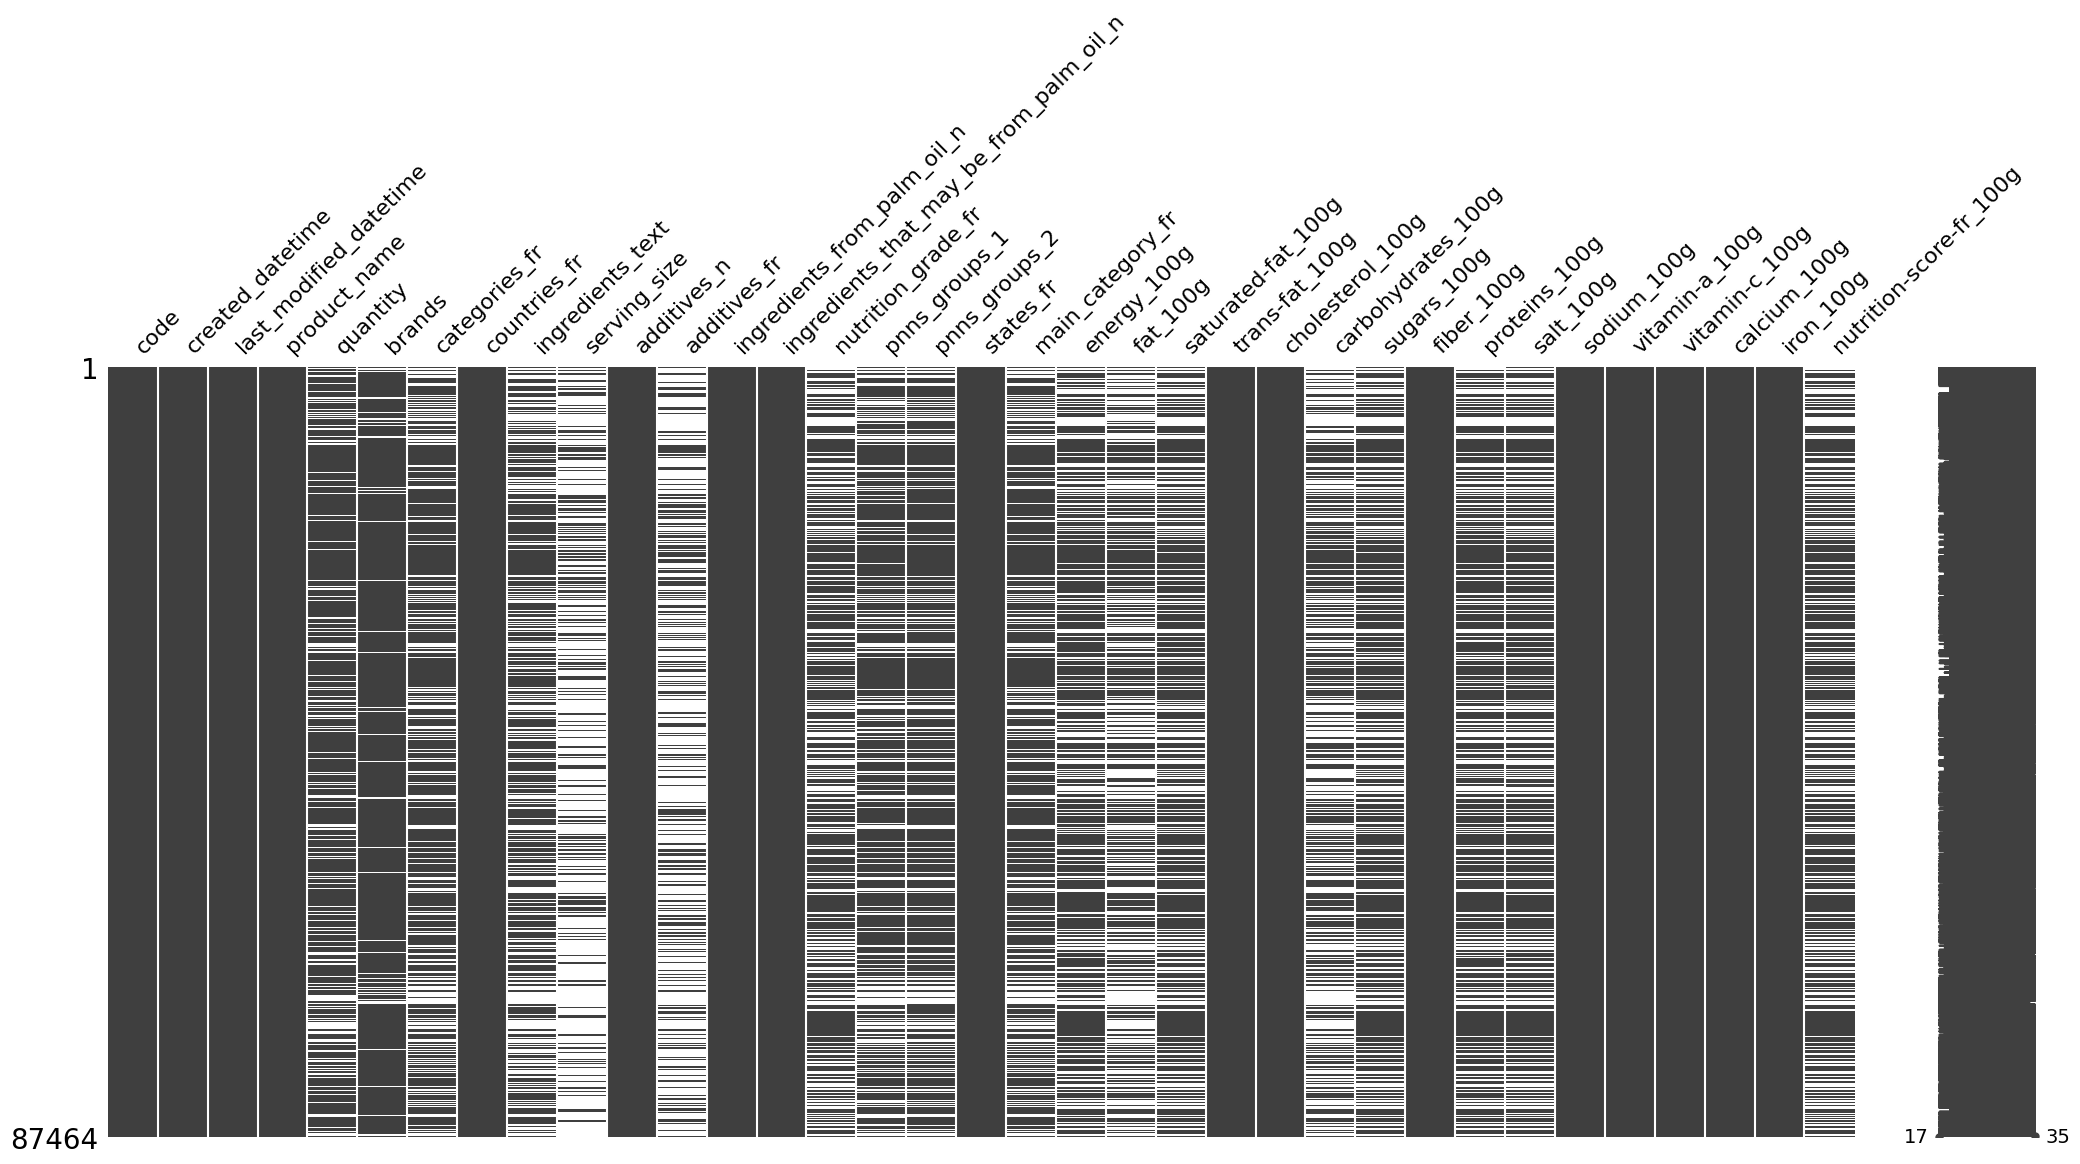

In [284]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_essentiel, True, True)

### Ingrédient mineur

Il faut noter que la loi française oblige l'affichage sur les emballages de produit alimentaire de la liste  des ingrédients, des ingrédients allergènes et la quantité de certains ingrédients. Elle n'oblige pas de lister l'intégralité des quantités des ingrédients existants. 

Source : [Ministère de l'économie des finances et de la souveraineté industrielle et numérique](https://www.economie.gouv.fr/particuliers/denrees-alimentaires-regles-etiquetage#)

____

Il y a de fortes chances que certains ingrédients ont des valeurs manquantes (NaN) car le jeu de donnée a été crée avec les inscriptions écrites sur l'emballage des produits alimentaires où elles ne sont donc pas mentionnées. 

Nous les appellerons les **ingrédient mineurs**.

Pour ces derniers, nous pouvons implémenter le chiffre 0 pour chaque Nan ainsi trouvé. 

In [208]:
# Liste des ingrédient mineurs
ingredient_mineur_list = [
    "additives_n", 
    "ingredients_from_palm_oil_n", 
    "ingredients_that_may_be_from_palm_oil_n",
    "cholesterol_100g",
    "fiber_100g",
    "sodium_100g",
    "vitamin-a_100g",
    "vitamin-c_100g",
    "calcium_100g",
    "iron_100g",
    "trans-fat_100g"
    ]

# df de travail est une copie du dfataframe des données
df_imputation = df_data_clean_essentiel.copy()

# POUR chaque ingédient mineur ALORS remplacer les NaN par 0
for col in ingredient_mineur_list:

    # Création du simple imputer pour  remplacer les NaN par une constante (0)
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=None)
    
    # Convertissez la colonne en un tableau numpy, puis un tableau 2D
    col_data = df_imputation[col].values  
    col_data_2d = col_data.reshape(-1, 1)
    
    # Utilisez la méthode fit_transform avec le tableau 2D
    df_imputation[col] = imputer.fit_transform(col_data_2d)

On compte les Nan dans la premiere colonne de 'ingredient_mineur_list' du dataframe des données avant la re-intégration

In [209]:
df_data_clean_essentiel[ingredient_mineur_list[0]].isna().sum()

36997

Nous re-integrons les valeurs du dataframe d'imputation dans le dataframe des données et on vérifie les NaN

In [210]:
# Remplacez les colonnes dans df_data_clean_france par celles de df_travail
df_data_clean_essentiel[ingredient_mineur_list] = df_imputation[ingredient_mineur_list].copy()

df_data_clean_essentiel[ingredient_mineur_list[0]].isna().sum()

C:\Users\pierr\AppData\Local\Temp\ipykernel_14964\3918124637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean_essentiel[ingredient_mineur_list] = df_imputation[ingredient_mineur_list].copy()


0

Faisons à nouveau un point sur les valeurs manquantes sur tout le dataframe

In [211]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_imputation, True, False)

Valeurs manquantes (Nan) : 578282 / 3061240 données (18.89 %)
18 / 35 colonne(s) sont concernés


,Nombres de valeurs manquantes,% de valeurs manquantes
brands,5745,6.570000
quantity,20065,22.940000
pnns_groups_2,25091,28.690000
energy_100g,26544,30.350000
proteins_100g,26559,30.370000
pnns_groups_1,27018,30.890000
salt_100g,28191,32.230000
sugars_100g,28253,32.300000
saturated-fat_100g,28339,32.400000
main_category_fr,29122,33.300000


### Ingrédient majeur

Egalement, la loi française oblige la déclaration nutritionnelle des informations concernant les quantité par 100g de certains éléments, à savoir : 
- l'énergie
- Les lipides
- Les acides gras saturés
- Les glucides
- les sucres
- les protéines
- le sel

Source : [Ministère de l'économie des finances et de la souveraineté industrielle et numérique](https://www.economie.gouv.fr/dgccrf/Publications/Vie-pratique/Fiches-pratiques/declaration-nutritionnelle-sur-denrees-alimentaires)

____

Il y a de fortes chances que le jeu de donnée a été crée avec les inscriptions écrites sur l'emballage des produits alimentaires. Cela implique que ces éléments doivent être systématiquement remplis. 

Nous les appellerons les **ingrédients majeurs**.

Pour ces derniers, nous devons avoir une valeur non nulle dans une grande partie des produits. Nous allons donc implémenter les NaN par des calculs de machine learning en utilant l'algorithme KNN. 


In [255]:
# Liste des ingrédient majeurs
ingredient_majeur_list = [
    "energy_100g", 
    "fat_100g", 
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g"
    ]

# df de travail est une copie des colonnes '_100g'
df_imputation = df_data_clean_essentiel.copy()
display(df_imputation.head(3))

,code,created_datetime,last_modified_datetime,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,1kg,Ferme t'y R'nao,NaN,France,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,0000000024600,2015-06-17 08:45:04+00:00,2015-06-17 10:11:54+00:00,Filet de bœuf,2.46 kg,NaN,Filet-de-boeuf,France,NaN,NaN,0.0,NaN,0.0,0.0,NaN,unknown,unknown,"A compléter,Informations nutritionnelles à com...",Filet-de-boeuf,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
3,0000000039259,2015-01-25 21:36:13+00:00,2016-09-10 20:08:02+00:00,Twix x2,NaN,NaN,NaN,France,NaN,NaN,0.0,NaN,0.0,0.0,NaN,unknown,unknown,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN


#### Distribution

Nous allons observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

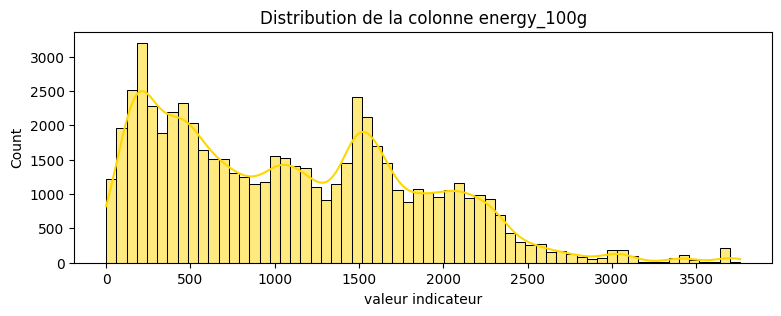

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,1098.30005,1023.5,761.09998,0.69,0.55,-0.3


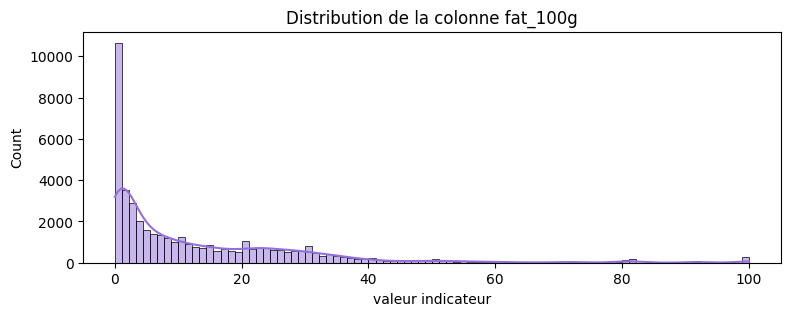

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,13.3,6.7,16.9,1.27,2.25,6.7


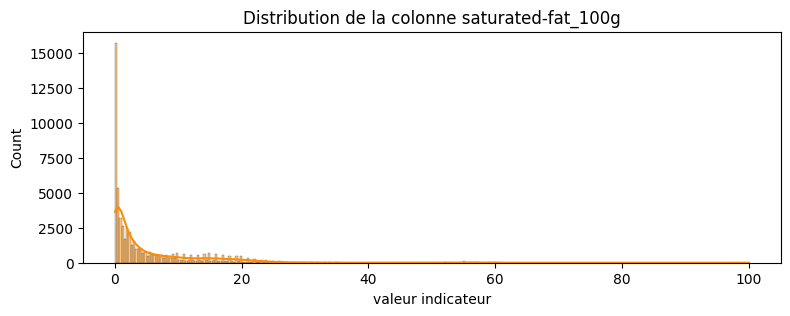

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,5.4,1.9,8.5,1.57,3.59,21.1


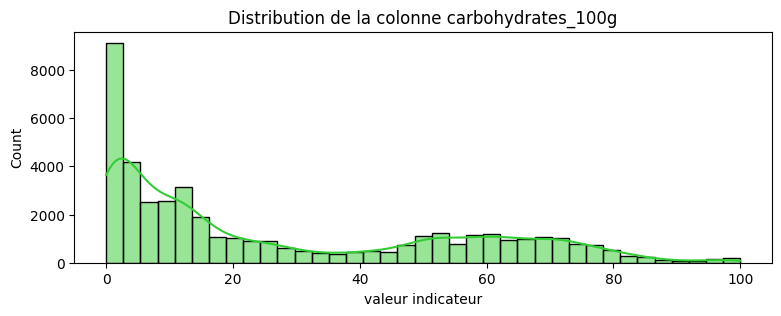

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,27.3,14.0,27.3,1.0,0.74,-0.9


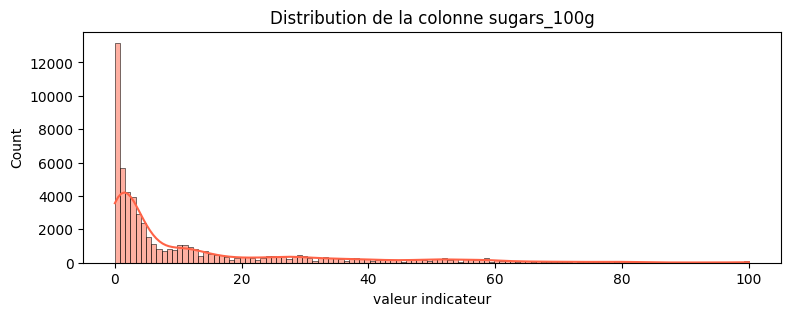

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,13.2,4.0,19.0,1.44,1.93,3.4


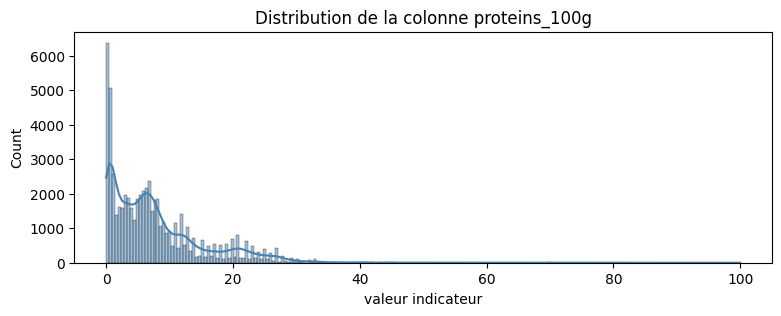

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,7.8,6.0,7.9,1.01,2.26,11.5


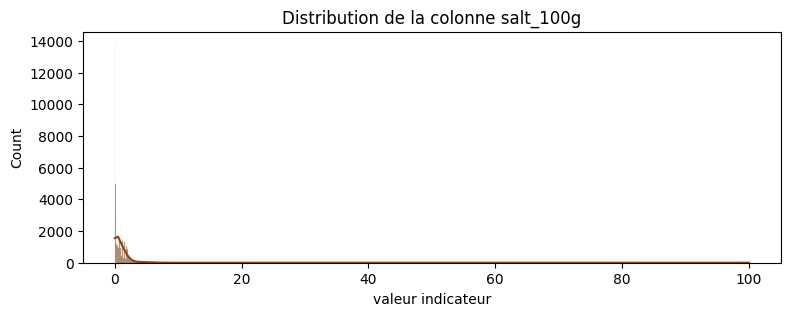

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,1.2,0.6,4.2,3.5,15.68,303.79999


In [268]:
# POUR chaque ingédient mineur ALORS remplacer les NaN par 0
for idx, col in enumerate(ingredient_majeur_list):
    
    # Courbe
    plot_distribution(df_imputation, col, colors1[idx])
    
    # Calcul des stats descriptives
    df_stat = stats_descriptives(df_imputation, col)
    display(df_stat)

<Axes: >

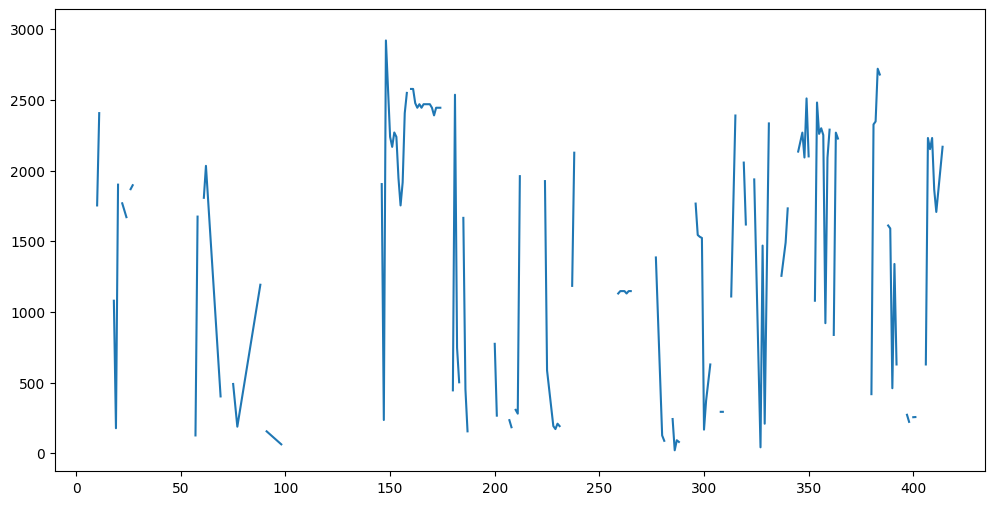

In [213]:
plt.figure(figsize=(12, 6))
df_imputation["energy_100g"].iloc[:300].plot()

#### Imputation

Nous allons utiliser l'imputation par le KNNImputer.

Dans un premier temps, il faut entrainer le modèle avec un échantillon aléatoire du dataframe

In [288]:
# Extraction d'un échantillon aléatoire de données à partir de df_imputation pour l'entraînement
sample_datas = df_imputation[ingredient_majeur_list].sample(frac=0.25, random_state=1)

# Créez un objet d'imputation KNN (5 voisins les plus proches, valeurs manquantes sont codées comme NaN)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

# Entraînez le modèle d'imputation KNN en utilisant l'échantillon de données
imputer.fit(sample_datas)

KNNImputer()

Maintenant que le modèle est entrainé, nous allons l'appliquer à nos colonnes

In [289]:
# Appliquez le modèle d'imputation KNN aux données sélectionnées
datas_imputed = imputer.transform(df_imputation[ingredient_majeur_list])

# Création nouveau DataFrame à partir des données imputées avec les mêmes col
df_datas_imputed = pd.DataFrame(datas_imputed, columns=ingredient_majeur_list)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

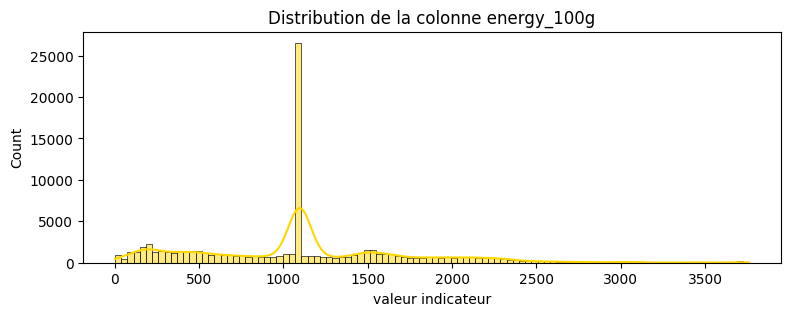

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,1102.5,1096.59998,639.90002,0.58,0.66,0.8


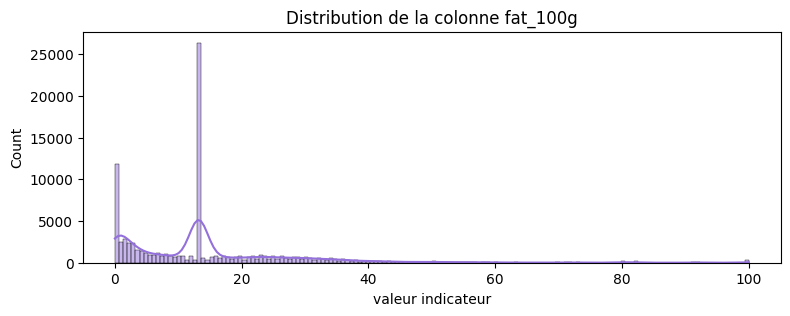

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,14.3,13.2,14.2,0.99,2.22,7.9


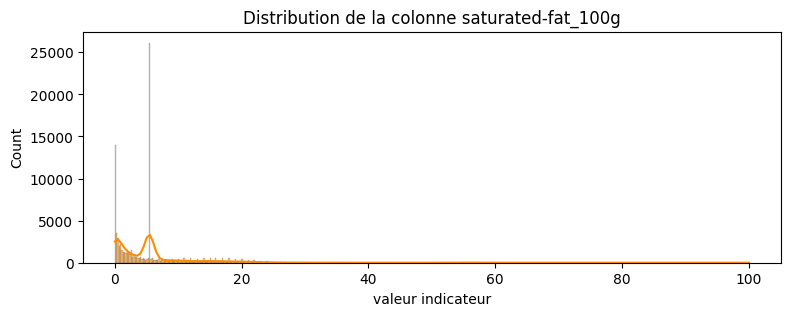

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,5.4,5.4,7.1,1.31,4.24,30.7


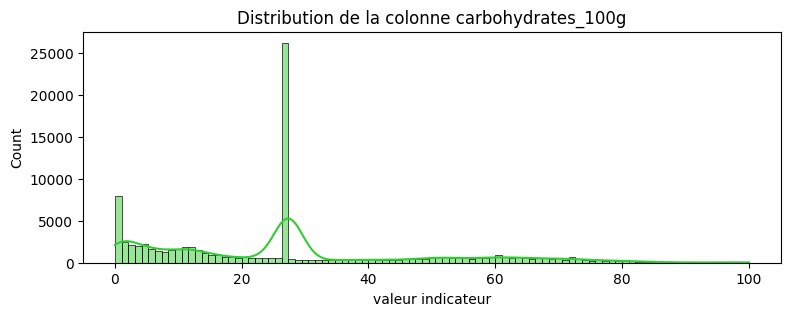

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,27.1,27.4,21.8,0.8,0.85,0.1


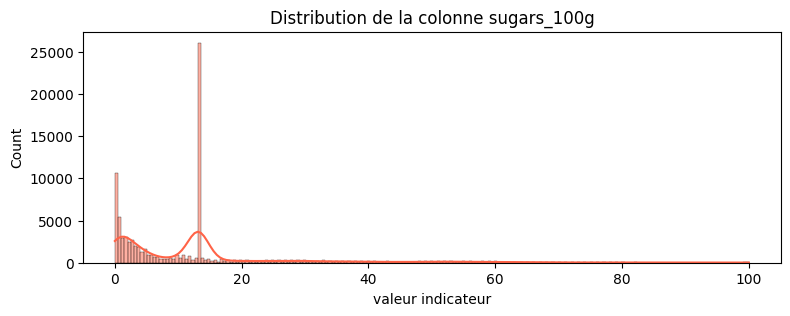

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,13.1,13.0,15.7,1.2,2.33,6.3


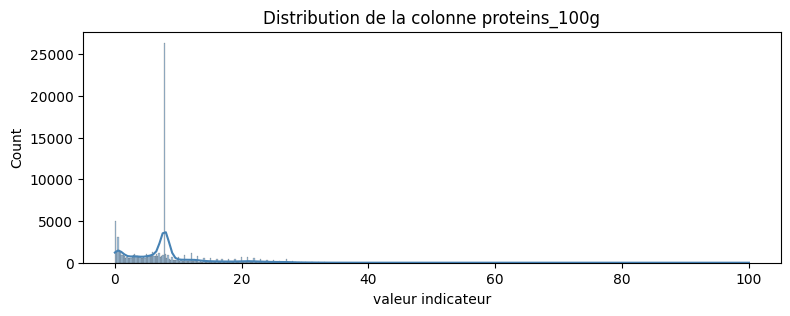

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,7.8,7.9,6.6,0.85,2.67,17.5


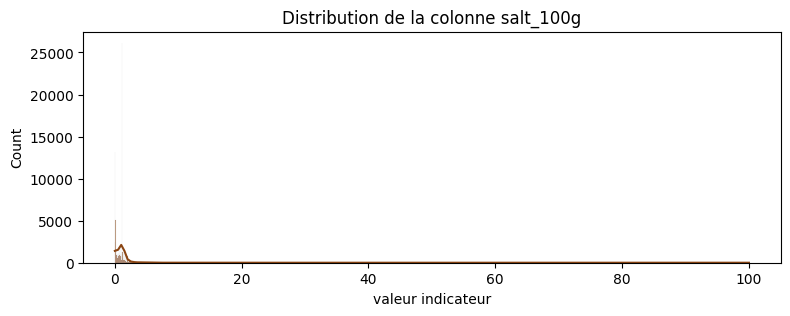

,moyenne,médiane,ecart-type,CV,skewness,kurtosis
0,1.2,1.1,3.5,2.92,18.82,442.0


In [283]:
# POUR chaque ingédient mineur ALORS remplacer les NaN par 0
for idx, col in enumerate(ingredient_majeur_list):
    
    # Courbe
    plot_distribution(df_datas_imputed, col, colors1[idx])
    
    # Calcul des stats descriptives
    df_stat = stats_descriptives(df_datas_imputed, col)
    display(df_stat)

<Axes: >

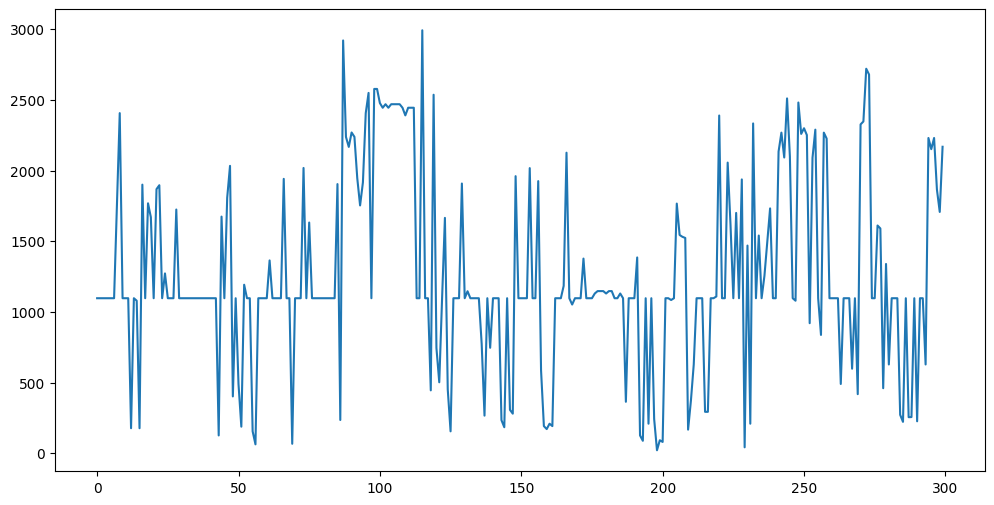

In [271]:
plt.figure(figsize=(12, 6))
df_datas_imputed["energy_100g"].iloc[:300].plot()

### Nutriscore

ici

## <span style='background:green'>7/ Traitement certaines variables catégorielles</span>

## <span style='background:green'>8/ Respect des normes RGPD</span>

Voici les 5 grand principe RGPD (Règlement sur la Protection des Données Personnelles) : 

1. **Finalité** : Les données sont collectées pour un but bien déterminé et légitime et ne sont pas traitées ultérieurement de façon incompatible avec cet objectif initial. 
   
2. **Pertinence** : Seules les données strictement nécessaires à la réalisation de l’objectif poursuivi doivent être collectées. Il s’agit donc de minimiser autant que possible la collecte des données.

3. **Durée limitée de conservation** : Les données ne doivent être conservées sous une forme identifiante et en « base active » que le temps nécessaire à la réalisation de l’objectif poursuivi et doivent être par la suite détruites, anonymisées ou archivées dans le respect des obligations légales applicables en matière de conservation des archives publiques.

4. **Sécurité** : Le responsable de traitement de la collectivité doit prendre toutes les mesures utiles pour garantir l’intégrité et la confidentialité de ces données, en s’assurant notamment que des tiers non autorisés n’y auront pas accès. 

5. **Droits des personnes** : Les personnes concernées par les traitements doivent conserver la maitrise des données qui les concernent. Ces droits « Informatique et Libertés », qu’elles peuvent exercer auprès de la collectivité qui détient ces informations sont :
    - le droit d’accéder à leurs données et d’en obtenir une copie
    - le droit de les rectifier
    - le droit de s’opposer à leur utilisation, sauf si le traitement répond à une obligation légale

Source : [CNIL](https://www.cnil.fr/fr/collectivites-territoriales/les-principes-cles-de-la-protection-des-donnees)

___

*Dans notre cas, les données ne concernent que des nutriments, des aliments, des marques, des produits de consommation. Aucune donnée personnelle n'est traité par ce travail.*

**=> Nous pouvons nous affranchir des obligations induites par cette loi RGPD.** 